<a href="https://colab.research.google.com/github/SharatGupta/DSML-Projects/blob/main/05%20Delhivery%20-%20Feature%20Engineering%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

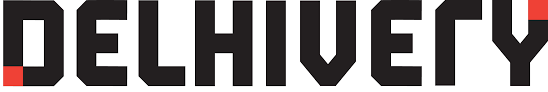
* Delhivery is the largest and fastest-growing fully integrated player in India by revenue in Fiscal 2021. They aim to build the operating system for commerce, through a combination of world-class infrastructure, logistics operations of the highest quality, and cutting-edge engineering and technology capabilities.

* The Data team builds intelligence and capabilities using this data that helps them to widen the gap between the quality, efficiency, and profitability of their business versus their competitors

# **Business Problem**

The company wants to understand and process the data coming out of data engineering pipelines:

• Clean, sanitize and manipulate data to get useful features out of raw fields

• Make sense out of the raw data and help the data science team to build forecasting models on it

# **Desired Outcome of Analysis**

* Basic data cleaning and exploration:
** Handle missing values in the data.
** Analyze the structure of the data.
** Try merging the rows using the hint mentioned above.
* Build some features to prepare the data for actual analysis. Extract features from the below fields:
** Destination Name: Split and extract features out of destination. City-place-code (State)
** Source Name: Split and extract features out of destination. City-place-code (State)
** Trip_creation_time: Extract features like month, year and day etc
* In-depth analysis and feature engineering
** Calculate the time taken between od_start_time and od_end_time and keep it as a feature. Drop the original columns, if required
** Compare the difference between Point a. and start_scan_to_end_scan. Do hypothesis testing/ Visual analysis to check.
** Do hypothesis testing/ visual analysis between actual_time aggregated value and OSRM time aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)
** Do hypothesis testing/ visual analysis between actual_time aggregated value and segment actual time aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)
** Do hypothesis testing/ visual analysis between osrm distance aggregated value and segment osrm distance aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)
** Do hypothesis testing/ visual analysis between osrm time aggregated value and segment osrm time aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)
** Find outliers in the numerical variables (you might find outliers in almost all the variables), and check it using visual analysis
** Handle the outliers using the IQR method.
** Do one-hot encoding of categorical variables (like route_type)
Normalize/ Standardize the numerical features using MinMaxScaler or StandardScaler






# **Loading Modules and Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from scipy.stats import  ttest_ind

from scipy.stats import shapiro,levene
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import mannwhitneyu

!pip install category_encoders
from category_encoders import TargetEncoder
!pip install sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
data = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv")

**Description of each column in data**
* data - tells whether the data is testing or training data
* trip_creation_time – Timestamp of trip creation
* route_schedule_uuid – Unique Id for a particular route schedule
* route_type – Transportation type
* FTL – Full Truck Load: FTL shipments get to the destination sooner, as the truck is making no other pickups or drop-offs along the way
Carting: Handling system consisting of small vehicles (carts)
* trip_uuid - Unique ID given to a particular trip (A trip may include different source and destination centers)
* source_center - Source ID of trip origin
* source_name - Source Name of trip origin
* destination_cente – Destination ID
* destination_name – Destination Name
* od_start_time – Trip start time
* od_end_time – Trip end time
* start_scan_to_end_scan – Time taken to deliver from source to destination
* is_cutoff – Unknown field
* cutoff_factor – Unknown field
* cutoff_timestamp – Unknown field
* actual_distance_to_destination – Distance in Kms between source and destination warehouse
* actual_time – Actual time taken to complete the delivery (Cumulative) (Also Include Human Operation time between tranfer from one segment to other)
* osrm_time – An open-source routing engine time calculator which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) and gives the time (Cumulative)
* osrm_distance – An open-source routing engine which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) (Cumulative)
* factor – Unknown field
* segment_actual_time – This is a segment time. Time taken by the subset of the package delivery (Only time for that segmentg, No human operation time involved)
* segment_osrm_time – This is the OSRM segment time. Time taken by the subset of the package delivery
* segment_osrm_distance – This is the OSRM distance. Distance covered by subset of the package delivery
* segment_factor – Unknown field

From above data we can infer that
* To check Operatioanl Efficiency, we can compare actual vs Segment wise sum
* To check accuracy of actual w.r.t Expected, we can compare Actual vs OSRM

# **Data Cleaning**

In [ ]:
data.shape

(144867, 24)

In [ ]:
data.head()

data          trip_creation_time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                 source_name  \
0  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
1  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
2  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
3  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
4  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   

  destination_center               destination_name  \
0       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
1       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
2       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
3       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
4       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   

                od_start_time  ...            cutoff_timestamp  \
0  2018-09-20 03:21:32.418600  ...         2018-09-20 04:27:55   
1  2018-09-20 03:21:32.418600  ...         2018-09-20 04:17:55   
2  2018-09-20 03:21:32.418600  ...  2018-09-20 04:01:19.505586   
3  2018-09-20 03:21:32.418600  ...         2018-09-20 03:39:57   
4  2018-09-20 03:21:32.418600  ...         2018-09-20 03:33:55   

   actual_distance_to_destination  actual_time  osrm_time osrm_distance  \
0                       10.435660         14.0       11.0       11.9653   
1                       18.936842         24.0       20.0       21.7243   
2                       27.637279         40.0       28.0       32.5395   
3                       36.118028         62.0       40.0       45.5620   
4                       39.386040         68.0       44.0       54.2181   

     factor  segment_actual_time  segment_osrm_time  segment_osrm_distance  \
0  1.272727                 14.0               11.0                11.9653   
1  1.200000                 10.0                9.0                 9.7590   
2  1.428571                 16.0                7.0                10.8152   
3  1.550000                 21.0               12.0                13.0224   
4  1.545455                  6.0                5.0                 3.9153   

   segment_factor  
0        1.272727  
1        1.111111  
2        2.285714  
3        1.750000  
4        1.200000  

[5 rows x 24 columns]

In [ ]:
data.columns

Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time',
       'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'segment_factor'],
      dtype='object')

In [ ]:
data.index

RangeIndex(start=0, stop=144867, step=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

## Dropping Unknown columns

Lets Drop the unknown Fields
* is_cutoff – Unknown field,
* cutoff_factor – Unknown field,
* cutoff_timestamp – Unknown field
* factor – Unknown field
* segment_factor – Unknown field


In [ ]:
data.drop(columns = ["is_cutoff","cutoff_factor","cutoff_timestamp","factor","segment_factor"], axis = 1,inplace= True)

In [ ]:
data.shape

(144867, 19)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  actual_distance_

## Datatype Conversion of Features

Lets convert possible Column to "Cateory" datatype
* route_type – Transportation type
* data - tells whether the data is testing or training data

In [ ]:
data["route_type"]=data["route_type"].astype("category")
data["data"]=data["data"].astype("category")

Lets Convert Datetime Columns as datatime64[ns]
* trip_creation_time – Timestamp of trip creation
* od_start_time – Trip start time
* od_end_time – Trip end time

In [ ]:
data["trip_creation_time"]=data["trip_creation_time"].astype("datetime64")
data["od_start_time"]=data["od_start_time"].astype("datetime64")
data["od_end_time"]=data["od_end_time"].astype("datetime64")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  category      
 1   trip_creation_time              144867 non-null  datetime64[ns]
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  category      
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144574 non-null  object        
 7   destination_center              144867 non-null  object        
 8   destination_name                144606 non-null  object        
 9   od_start_time                   144867 non-null  datetime64[ns]
 10  od_end_time                     144867 non-null  datetim

## Duplicate Values & Their Treatment

In [ ]:
data.loc[data.duplicated()]

Empty DataFrame
Columns: [data, trip_creation_time, route_schedule_uuid, route_type, trip_uuid, source_center, source_name, destination_center, destination_name, od_start_time, od_end_time, start_scan_to_end_scan, actual_distance_to_destination, actual_time, osrm_time, osrm_distance, segment_actual_time, segment_osrm_time, segment_osrm_distance]
Index: []

No duplicate rows found

## Missingvalues & Their Treatment

In [ ]:
data.isna().sum(axis = 0)

data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
dtype: int64

* Missing Values are present only in source_name & Destination_name
* As there are not missing values in source_centre & destination_centre, we can check if Source_name & Destination_name existing in any of the rows

In [ ]:
sourcenamemissingsourcesentre = data.loc[data["source_name"].isnull() == True]["source_center"].unique()
sourcenamemissingsourcesentre

array(['IND342902A1B', 'IND577116AAA', 'IND282002AAD', 'IND465333A1B',
       'IND841301AAC', 'IND509103AAC', 'IND126116AAA', 'IND331022A1B',
       'IND505326AAB', 'IND852118A1B'], dtype=object)

In [ ]:
j = 1
for i in sourcenamemissingsourcesentre:
  missedsourcename = data.loc[data["source_center"] == i]["source_name"].unique()
  if pd.isna(missedsourcename):
    data.loc[data["source_center"] == i,"source_name"] = "unknownsource "+str(j)
    j+=1
  else:
    data.loc[data["source_center"] == i,"source_name"]["source_name"] = missedsourcename[:1]

In [ ]:
for i in sourcenamemissingsourcesentre:
  print(i, data.loc[data["source_center"] == i]["source_name"].unique())

IND342902A1B ['unknownsource 1']
IND577116AAA ['unknownsource 2']
IND282002AAD ['unknownsource 3']
IND465333A1B ['unknownsource 4']
IND841301AAC ['unknownsource 5']
IND509103AAC ['unknownsource 6']
IND126116AAA ['unknownsource 7']
IND331022A1B ['unknownsource 8']
IND505326AAB ['unknownsource 9']
IND852118A1B ['unknownsource 10']


In [ ]:
destinationnamemissingdestinationsentre = data.loc[data["destination_name"].isnull() == True]["destination_center"].unique()
destinationnamemissingdestinationsentre

array(['IND342902A1B', 'IND577116AAA', 'IND282002AAD', 'IND465333A1B',
       'IND841301AAC', 'IND505326AAB', 'IND852118A1B', 'IND126116AAA',
       'IND509103AAC', 'IND221005A1A', 'IND250002AAC', 'IND331001A1C',
       'IND122015AAC'], dtype=object)

In [ ]:
j = 1
for i in destinationnamemissingdestinationsentre:
  misseddestinationname = data.loc[data["destination_center"] == i]["destination_name"].unique()
  if pd.isna(misseddestinationname):
    data.loc[data["destination_center"] == i,"destination_name"] = "unknowndestination "+str(j)
    j+=1
  else:
    data.loc[data["destination_center"] == i,"destination_name"]["destination_name"] = misseddestinationname[:1]

In [ ]:
for i in destinationnamemissingdestinationsentre:
  print(i, data.loc[data["destination_center"] == i]["destination_name"].unique())

IND342902A1B ['unknowndestination 1']
IND577116AAA ['unknowndestination 2']
IND282002AAD ['unknowndestination 3']
IND465333A1B ['unknowndestination 4']
IND841301AAC ['unknowndestination 5']
IND505326AAB ['unknowndestination 6']
IND852118A1B ['unknowndestination 7']
IND126116AAA ['unknowndestination 8']
IND509103AAC ['unknowndestination 9']
IND221005A1A ['unknowndestination 10']
IND250002AAC ['unknowndestination 11']
IND331001A1C ['unknowndestination 12']
IND122015AAC ['unknowndestination 13']


In [ ]:
data.isna().sum(axis=0)

data                              0
trip_creation_time                0
route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
od_start_time                     0
od_end_time                       0
start_scan_to_end_scan            0
actual_distance_to_destination    0
actual_time                       0
osrm_time                         0
osrm_distance                     0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
dtype: int64

* All Missing items of source_name & destination_name have been Filled

## Merging Rows

* Let us verify one trip_uuid & one route_schedule_uuid Details & see how multiple rows can be merged

In [ ]:
data.loc[data["trip_uuid"] == data["trip_uuid"].unique()[0]]

data         trip_creation_time  \
0  training 2018-09-20 02:35:36.476840   
1  training 2018-09-20 02:35:36.476840   
2  training 2018-09-20 02:35:36.476840   
3  training 2018-09-20 02:35:36.476840   
4  training 2018-09-20 02:35:36.476840   
5  training 2018-09-20 02:35:36.476840   
6  training 2018-09-20 02:35:36.476840   
7  training 2018-09-20 02:35:36.476840   
8  training 2018-09-20 02:35:36.476840   
9  training 2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
5  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
6  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
7  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
8  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
9  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                    source_name  \
0  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
1  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
2  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
3  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
4  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
5  trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
6  trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
7  trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
8  trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
9  trip-153741093647649320  IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   

  destination_center               destination_name  \
0       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
1       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
2       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
3       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
4       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
5       IND388320AAA     Anand_Vaghasi_IP (Gujarat)   
6       IND388320AAA     Anand_Vaghasi_IP (Gujarat)   
7       IND388320AAA     Anand_Vaghasi_IP (Gujarat)   
8       IND388320AAA     Anand_Vaghasi_IP (Gujarat)   
9       IND388320AAA     Anand_Vaghasi_IP (Gujarat)   

               od_start_time                od_end_time  \
0 2018-09-20 03:21:32.418600 2018-09-20 04:47:45.236797   
1 2018-09-20 03:21:32.418600 2018-09-20 04:47:45.236797   
2 2018-09-20 03:21:32.418600 2018-09-20 04:47:45.236797   
3 2018-09-20 03:21:32.418600 2018-09-20 04:47:45.236797   
4 2018-09-20 03:21:32.418600 2018-09-20 04:47:45.236797   
5 2018-09-20 04:47:45.236797 2018-09-20 06:36:55.627764   
6 2018-09-20 04:47:45.236797 2018-09-20 06:36:55.627764   
7 2018-09-20 04:47:45.236797 2018-09-20 06:36:55.627764   
8 2018-09-20 04:47:45.236797 2018-09-20 06:36:55.627764   
9 2018-09-20 04:47:45.236797 2018-09-20 06:36:55.627764   

   start_scan_to_end_scan  actual_distance_to_destination  actual_time  \
0                    86.0                       10.435660         14.0   
1                    86.0                       18.936842         24.0   
2                    86.0                       27.637279         40.0   
3                    86.0                       36.118028         62.0   
4                    86.0                       39.386040         68.0   
5                   109.0                       10.403038         15.0   
6                   109.0                       18.045481         44.0   
7                   109.0                       28.061896         65.0   
8                   109.0                       38.939167 

In [ ]:
data.loc[data["route_schedule_uuid"] == data["route_schedule_uuid"].unique()[0]]["trip_uuid"].value_counts()

trip-153680339869927048    11
trip-153697725798753764    11
trip-153818828153597720    11
trip-153741093647649320    10
trip-153757917674683146    10
trip-153792558519954345    10
trip-153810169136762438    10
trip-153836091722390431    10
trip-153671811509671845    10
trip-153801468900715290    10
trip-153689022134280351     6
trip-153723562875380861     5
trip-153853302491268026     5
trip-153845108130043002     5
Name: trip_uuid, dtype: int64

In [ ]:
data.loc[data["route_schedule_uuid"] == data["route_schedule_uuid"].unique()[0]]["source_name"].value_counts()

Khambhat_MotvdDPP_D (Gujarat)    69
Anand_VUNagar_DC (Gujarat)       54
Anand_Vaghasi_IP (Gujarat)        1
Name: source_name, dtype: int64

In [ ]:
data.loc[data["route_schedule_uuid"] == data["route_schedule_uuid"].unique()[0]]["destination_name"].value_counts()

Anand_Vaghasi_IP (Gujarat)       69
Khambhat_MotvdDPP_D (Gujarat)    54
Anand_VUNagar_DC (Gujarat)        1
Name: destination_name, dtype: int64

* From above 4 cell we can say that "route_schedule_uuid" futher consists of many "trip_uuid"
* Further each "trip_uuid has many destination & sources -- Because of this we cannot directly "groupby" on "trip_uuid"
* First we will use "groupby" on 3 columns - ['trip_uuid','source_center','destination_center'] and use aggregations as needed for each feature & again then we will "groupby"" on 1 column "trip_uuid"

### Merging1

In [ ]:
data1 = data.groupby(['trip_uuid','source_center','destination_center']).agg({'data' : 'first',
'route_schedule_uuid' : 'first' ,
'route_type' : 'first',
'trip_creation_time' : 'first',
'source_name' : 'first',
'destination_name' : 'last',
'od_start_time' : 'first',
'od_end_time' : 'first',
'start_scan_to_end_scan' : 'first',
'actual_distance_to_destination' : 'last',
'actual_time' : 'last',
'osrm_time' : 'last',
'osrm_distance' : 'last',
'segment_actual_time' : 'sum',
'segment_osrm_time' : 'sum',
'segment_osrm_distance' : 'sum'}).reset_index()

In [ ]:
data.shape

(144867, 19)

In [ ]:
data1.shape

(26368, 19)

In [ ]:
data1.head(5)

trip_uuid source_center destination_center      data  \
0  trip-153671041653548748  IND209304AAA       IND000000ACB  training   
1  trip-153671041653548748  IND462022AAA       IND209304AAA  training   
2  trip-153671042288605164  IND561203AAB       IND562101AAA  training   
3  trip-153671042288605164  IND572101AAA       IND561203AAB  training   
4  trip-153671043369099517  IND000000ACB       IND160002AAC  training   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
2  thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
3  thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
4  thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   

          trip_creation_time                         source_name  \
0 2018-09-12 00:00:16.535741  Kanpur_Central_H_6 (Uttar Pradesh)   
1 2018-09-12 00:00:16.535741  Bhopal_Trnsport_H (Madhya Pradesh)   
2 2018-09-12 00:00:22.886430   Doddablpur_ChikaDPP_D (Karnataka)   
3 2018-09-12 00:00:22.886430       Tumkur_Veersagr_I (Karnataka)   
4 2018-09-12 00:00:33.691250       Gurgaon_Bilaspur_HB (Haryana)   

                     destination_name              od_start_time  \
0       Gurgaon_Bilaspur_HB (Haryana) 2018-09-12 16:39:46.858469   
1  Kanpur_Central_H_6 (Uttar Pradesh) 2018-09-12 00:00:16.535741   
2   Chikblapur_ShntiSgr_D (Karnataka) 2018-09-12 02:03:09.655591   
3   Doddablpur_ChikaDPP_D (Karnataka) 2018-09-12 00:00:22.886430   
4      Chandigarh_Mehmdpur_H (Punjab) 2018-09-14 03:40:17.106733   

                 od_end_time  start_scan_to_end_scan  \
0 2018-09-13 13:40:23.123744                  1260.0   
1 2018-09-12 16:39:46.858469                   999.0   
2 2018-09-12 03:01:59.598855                    58.0   
3 2018-09-12 02:03:09.655591                   122.0   
4 2018-09-14 17:34:55.442454                   834.0   

   actual_distance_to_destination  actual_time  osrm_time  osrm_distance  \
0                      383.759164        732.0      329.0       446.5496   
1                      440.973689        830.0      388.0       544.8027   
2                       24.644021         47.0       26.0        28.1994   
3                       48.542890         96.0       42.0        56.9116   
4                      237.439610        611.0      212.0       281.2109   

   segment_actual_time  segment_osrm_time  segment_osrm_distance  
0                728.0              534.0               670.6205  
1                820.0              474.0               649.8528  
2                 46.0               26.0                28.1995  
3                 95.0               39.0                55.9899  
4                608.0              231.0               317.7408

### Merging2

* Now lets do second groupby with only "trip_uuid"
* Here we have to sort any of "od-start_time" or "od_end_time" for each  "trip_uuid" to ensure we get correct initial source & final destination for each trip_uuid


In [ ]:
data1.sort_values(by=['trip_uuid', 'od_start_time'], ascending=[True,True],inplace = True,ignore_index=True)

In [ ]:
data2 = data1.groupby(['trip_uuid']).agg({'data' : 'first',
'route_schedule_uuid' : 'first' ,
'route_type' : 'first',
'trip_creation_time' : 'first',
'source_name' : 'first','source_center' : 'first',
'destination_name' : 'last','destination_center' : 'last',
'od_start_time' : 'first',
'od_end_time' : 'last',
'start_scan_to_end_scan' : 'sum',
'actual_distance_to_destination' : 'sum',
'actual_time' : 'sum',
'osrm_time' : 'sum',
'osrm_distance' : 'sum',
'segment_actual_time' : 'sum',
'segment_osrm_time' : 'sum',
'segment_osrm_distance' : 'sum'}).reset_index()

In [ ]:
data1.shape

(26368, 19)

In [ ]:
data2.shape

(14817, 19)

In [ ]:
data2.head(5)

trip_uuid      data  \
0  trip-153671041653548748  training   
1  trip-153671042288605164  training   
2  trip-153671043369099517  training   
3  trip-153671046011330457  training   
4  trip-153671052974046625  training   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1  thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
2  thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
3  thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...    Carting   
4  thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...        FTL   

          trip_creation_time                         source_name  \
0 2018-09-12 00:00:16.535741  Bhopal_Trnsport_H (Madhya Pradesh)   
1 2018-09-12 00:00:22.886430       Tumkur_Veersagr_I (Karnataka)   
2 2018-09-12 00:00:33.691250    Bangalore_Nelmngla_H (Karnataka)   
3 2018-09-12 00:01:00.113710            Mumbai Hub (Maharashtra)   
4 2018-09-12 00:02:09.740725              Bellary_Dc (Karnataka)   

  source_center                   destination_name destination_center  \
0  IND462022AAA      Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   
1  IND572101AAA  Chikblapur_ShntiSgr_D (Karnataka)       IND562101AAA   
2  IND562132AAA     Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
3  IND400072AAB     Mumbai_MiraRd_IP (Maharashtra)       IND401104AAA   
4  IND583101AAA             Bellary_Dc (Karnataka)       IND583101AAA   

               od_start_time                od_end_time  \
0 2018-09-12 00:00:16.535741 2018-09-13 13:40:23.123744   
1 2018-09-12 00:00:22.886430 2018-09-12 03:01:59.598855   
2 2018-09-12 00:00:33.691250 2018-09-14 17:34:55.442454   
3 2018-09-12 00:01:00.113710 2018-09-12 01:41:29.809822   
4 2018-09-12 00:02:09.740725 2018-09-12 12:00:30.683231   

   start_scan_to_end_scan  actual_distance_to_destination  actual_time  \
0                  2259.0                      824.732854       1562.0   
1                   180.0                       73.186911        143.0   
2                  3933.0                     1927.404273       3347.0   
3                   100.0                       17.175274         59.0   
4                   717.0                      127.448500        341.0   

   osrm_time  osrm_distance  segment_actual_time  segment_osrm_time  \
0      717.0       991.3523               1548.0             1008.0   
1       68.0        85.1110                141.0               65.0   
2     1740.0      2354.0665               3308.0             1941.0   
3       15.0        19.6800                 59.0               16.0   
4      117.0       146.7918                340.0              115.0   

   segment_osrm_distance  
0              1320.4733  
1                84.1894  
2              2545.2678  
3                19.8766  
4               146.7919

### Recheck on Merged Data

In [ ]:
data.loc[data["trip_uuid"] == "trip-153671041653548748"]

data         trip_creation_time  \
124981  training 2018-09-12 00:00:16.535741   
124982  training 2018-09-12 00:00:16.535741   
124983  training 2018-09-12 00:00:16.535741   
124984  training 2018-09-12 00:00:16.535741   
124985  training 2018-09-12 00:00:16.535741   
124986  training 2018-09-12 00:00:16.535741   
124987  training 2018-09-12 00:00:16.535741   
124988  training 2018-09-12 00:00:16.535741   
124989  training 2018-09-12 00:00:16.535741   
124990  training 2018-09-12 00:00:16.535741   
124991  training 2018-09-12 00:00:16.535741   
124992  training 2018-09-12 00:00:16.535741   
124993  training 2018-09-12 00:00:16.535741   
124994  training 2018-09-12 00:00:16.535741   
124995  training 2018-09-12 00:00:16.535741   
124996  training 2018-09-12 00:00:16.535741   
124997  training 2018-09-12 00:00:16.535741   
124998  training 2018-09-12 00:00:16.535741   
124999  training 2018-09-12 00:00:16.535741   
125000  training 2018-09-12 00:00:16.535741   
125001  training 2018-09-12 00:00:16.535741   
125002  training 2018-09-12 00:00:16.535741   
125003  training 2018-09-12 00:00:16.535741   
125004  training 2018-09-12 00:00:16.535741   
125005  training 2018-09-12 00:00:16.535741   
125006  training 2018-09-12 00:00:16.535741   
125007  training 2018-09-12 00:00:16.535741   
125008  training 2018-09-12 00:00:16.535741   
125009  training 2018-09-12 00:00:16.535741   
125010  training 2018-09-12 00:00:16.535741   
125011  training 2018-09-12 00:00:16.535741   
125012  training 2018-09-12 00:00:16.535741   
125013  training 2018-09-12 00:00:16.535741   
125014  training 2018-09-12 00:00:16.535741   
125015  training 2018-09-12 00:00:16.535741   
125016  training 2018-09-12 00:00:16.535741   
125017  training 2018-09-12 00:00:16.535741   
125018  training 2018-09-12 00:00:16.535741   
125019  training 2018-09-12 00:00:16.535741   

                                      route_schedule_uuid route_type  \
124981  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124982  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124983  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124984  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124985  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124986  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124987  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124988  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124989  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124990  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124991  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124992  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124993  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124994  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124995  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124996  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124997  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124998  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
124999  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125000  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125001  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125002  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125003  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125004  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125005  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125006  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125007  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125008  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
125009  thanos::sroute:d7c989ba-a29b-4a0b-b

In [ ]:
data1.loc[data1["trip_uuid"] == "trip-153671041653548748"]

trip_uuid source_center destination_center      data  \
0  trip-153671041653548748  IND462022AAA       IND209304AAA  training   
1  trip-153671041653548748  IND209304AAA       IND000000ACB  training   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   

          trip_creation_time                         source_name  \
0 2018-09-12 00:00:16.535741  Bhopal_Trnsport_H (Madhya Pradesh)   
1 2018-09-12 00:00:16.535741  Kanpur_Central_H_6 (Uttar Pradesh)   

                     destination_name              od_start_time  \
0  Kanpur_Central_H_6 (Uttar Pradesh) 2018-09-12 00:00:16.535741   
1       Gurgaon_Bilaspur_HB (Haryana) 2018-09-12 16:39:46.858469   

                 od_end_time  start_scan_to_end_scan  \
0 2018-09-12 16:39:46.858469                   999.0   
1 2018-09-13 13:40:23.123744                  1260.0   

   actual_distance_to_destination  actual_time  osrm_time  osrm_distance  \
0                      440.973689        830.0      388.0       544.8027   
1                      383.759164        732.0      329.0       446.5496   

   segment_actual_time  segment_osrm_time  segment_osrm_distance  
0                820.0              474.0               649.8528  
1                728.0              534.0               670.6205

In [ ]:
data2.loc[data2["trip_uuid"] == "trip-153671041653548748"]

trip_uuid      data  \
0  trip-153671041653548748  training   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   

          trip_creation_time                         source_name  \
0 2018-09-12 00:00:16.535741  Bhopal_Trnsport_H (Madhya Pradesh)   

  source_center               destination_name destination_center  \
0  IND462022AAA  Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   

               od_start_time                od_end_time  \
0 2018-09-12 00:00:16.535741 2018-09-13 13:40:23.123744   

   start_scan_to_end_scan  actual_distance_to_destination  actual_time  \
0                  2259.0                      824.732854       1562.0   

   osrm_time  osrm_distance  segment_actual_time  segment_osrm_time  \
0      717.0       991.3523               1548.0             1008.0   

   segment_osrm_distance  
0              1320.4733

* As can be seen from above 3 cells now we can single row for each "trip_uuid" with proper od_start_time,od_end_time, Source & Destination details with summed up Distance and time values

## Preparation for Feature Engineering

### Reducing Features

* "od_start_time" & "od_end_time"can be converted to single feature by calcualting time difeence between both

In [ ]:
data2['od_total_time'] = (data2['od_end_time'] - data2['od_start_time']) / np.timedelta64(1, 'm')
data2.drop(columns = ['od_end_time', 'od_start_time'], inplace = True)
data2.head()

trip_uuid      data  \
0  trip-153671041653548748  training   
1  trip-153671042288605164  training   
2  trip-153671043369099517  training   
3  trip-153671046011330457  training   
4  trip-153671052974046625  training   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1  thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
2  thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
3  thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...    Carting   
4  thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...        FTL   

          trip_creation_time                         source_name  \
0 2018-09-12 00:00:16.535741  Bhopal_Trnsport_H (Madhya Pradesh)   
1 2018-09-12 00:00:22.886430       Tumkur_Veersagr_I (Karnataka)   
2 2018-09-12 00:00:33.691250    Bangalore_Nelmngla_H (Karnataka)   
3 2018-09-12 00:01:00.113710            Mumbai Hub (Maharashtra)   
4 2018-09-12 00:02:09.740725              Bellary_Dc (Karnataka)   

  source_center                   destination_name destination_center  \
0  IND462022AAA      Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   
1  IND572101AAA  Chikblapur_ShntiSgr_D (Karnataka)       IND562101AAA   
2  IND562132AAA     Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
3  IND400072AAB     Mumbai_MiraRd_IP (Maharashtra)       IND401104AAA   
4  IND583101AAA             Bellary_Dc (Karnataka)       IND583101AAA   

   start_scan_to_end_scan  actual_distance_to_destination  actual_time  \
0                  2259.0                      824.732854       1562.0   
1                   180.0                       73.186911        143.0   
2                  3933.0                     1927.404273       3347.0   
3                   100.0                       17.175274         59.0   
4                   717.0                      127.448500        341.0   

   osrm_time  osrm_distance  segment_actual_time  segment_osrm_time  \
0      717.0       991.3523               1548.0             1008.0   
1       68.0        85.1110                141.0               65.0   
2     1740.0      2354.0665               3308.0             1941.0   
3       15.0        19.6800                 59.0               16.0   
4      117.0       146.7918                340.0              115.0   

   segment_osrm_distance  od_total_time  
0              1320.4733    2260.109800  
1                84.1894     181.611874  
2              2545.2678    3934.362520  
3                19.8766     100.494935  
4               146.7919     718.349042

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817 entries, 0 to 14816
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   trip_uuid                       14817 non-null  object        
 1   data                            14817 non-null  category      
 2   route_schedule_uuid             14817 non-null  object        
 3   route_type                      14817 non-null  category      
 4   trip_creation_time              14817 non-null  datetime64[ns]
 5   source_name                     14817 non-null  object        
 6   source_center                   14817 non-null  object        
 7   destination_name                14817 non-null  object        
 8   destination_center              14817 non-null  object        
 9   start_scan_to_end_scan          14817 non-null  float64       
 10  actual_distance_to_destination  14817 non-null  float64       
 11  ac

### Create New Features

#### Extract features like month, year, day & week from Trip_creation_time

In [ ]:
data2['trip_creation_hour'] = data2['trip_creation_time'].dt.hour
data2['trip_creation_day'] = data2['trip_creation_time'].dt.day
data2['trip_creation_week'] = data2['trip_creation_time'].dt.isocalendar().week
data2['trip_creation_month'] = data2['trip_creation_time'].dt.month
data2['trip_creation_year'] = data2['trip_creation_time'].dt.year

All 5 above new Features are Cateogorical type, So lets convert them into Category Datatype

In [ ]:
data2['trip_creation_hour'] = data2['trip_creation_hour'].astype("category")
data2['trip_creation_day'] = data2['trip_creation_day'].astype("category")
data2['trip_creation_week'] = data2['trip_creation_week'].astype("category")
data2['trip_creation_month'] = data2['trip_creation_month'].astype("category")
data2['trip_creation_year'] = data2['trip_creation_year'].astype("category")

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817 entries, 0 to 14816
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   trip_uuid                       14817 non-null  object        
 1   data                            14817 non-null  category      
 2   route_schedule_uuid             14817 non-null  object        
 3   route_type                      14817 non-null  category      
 4   trip_creation_time              14817 non-null  datetime64[ns]
 5   source_name                     14817 non-null  object        
 6   source_center                   14817 non-null  object        
 7   destination_name                14817 non-null  object        
 8   destination_center              14817 non-null  object        
 9   start_scan_to_end_scan          14817 non-null  float64       
 10  actual_distance_to_destination  14817 non-null  float64       
 11  ac

In [ ]:
data2.nunique()

trip_uuid                         14817
data                                  2
route_schedule_uuid                1504
route_type                            2
trip_creation_time                14817
source_name                         868
source_center                       868
destination_name                    956
destination_center                  956
start_scan_to_end_scan             2208
actual_distance_to_destination    14801
actual_time                        1853
osrm_time                           817
osrm_distance                     14734
segment_actual_time                1890
segment_osrm_time                  1242
segment_osrm_distance             14754
od_total_time                     14817
trip_creation_hour                   24
trip_creation_day                    22
trip_creation_week                    4
trip_creation_month                   2
trip_creation_year                    1
dtype: int64

* In this Dataset "trip_creation_year" is having only 1 unique values, this feature can be dropped
* However we will keep the feature for now [ so that this code can be generalized for any similar dataset in future]

#### Extract Feature like City,State from "source_name" & "destination_name"

In [ ]:
data2["source_name"].unique()[:10]

array(['Bhopal_Trnsport_H (Madhya Pradesh)',
       'Tumkur_Veersagr_I (Karnataka)',
       'Bangalore_Nelmngla_H (Karnataka)', 'Mumbai Hub (Maharashtra)',
       'Bellary_Dc (Karnataka)', 'Chennai_Porur_DPC (Tamil Nadu)',
       'Chennai_Chrompet_DPC (Tamil Nadu)', 'HBR Layout PC (Karnataka)',
       'Surat_Central_I_4 (Gujarat)', 'Delhi_Lajpat_IP (Delhi)'],
      dtype=object)

* we will have to use multiple split function to separate State, City & Place_code
* We will create functions to commonly apply for destination_name & source_name

In [ ]:
def state(x):
  y = x.split("(")
  if len(y) == 2:
    return y[1].replace(")","")
  elif len(y)== 1:
    return x

In [ ]:
state('Mumbai Hub (Maharashtra)')

'Maharashtra'

In [ ]:
state("unknownsource 1")

'unknownsource 1'

In [ ]:
"city_place_code_state".split("_")

['city', 'place', 'code', 'state']

In [ ]:
def city(x):
  if "unknown" in x:
    return x
  elif "_" in x:
    y=x.split("_")
  else:
    y=x.split(" ")
  if len(y)>1:
    return y[0]

In [ ]:
city('Mumbai Hub (Maharashtra)')

'Mumbai'

In [ ]:
city('Chennai_Porur_DPC (Tamil Nadu)')

'Chennai'

In [ ]:
city("unknownsource 1")

'unknownsource 1'

In [ ]:
"city_place_code_state".split("_",1)

['city', 'place_code_state']

In [ ]:
def place(x):
  if "unknown" in x:
    return x
  elif "_" in x:
    y=x.split("_",1)
  else:
    y=x.split(" ",1)
  z = y[1].split(" (")
  return z[0]

In [ ]:
place('Mumbai Hub (Maharashtra)')

'Hub'

In [ ]:
place('Chennai_Porur_DPC (Tamil Nadu)')

'Porur_DPC'

In [ ]:
place("unknownsource 1")

'unknownsource 1'

* All 3 User Functions state(),city(),place() are created and checked for proper functionality for ll types of inputs
* Now we will use these functions to create 3 new feature(State, City, Place) from sourc_name & destination_name

In [ ]:
data2["source_state"] = data2["source_name"].apply(state)
data2["source_city"] = data2["source_name"].apply(city)
data2["source_place"] = data2["source_name"].apply(place)
data2["destination_state"] = data2["destination_name"].apply(state)
data2["destination_city"] = data2["destination_name"].apply(city)
data2["destination_place"] = data2["destination_name"].apply(place)

In [ ]:
data2["destination_state"]

0              Haryana
1            Karnataka
2               Punjab
3          Maharashtra
4            Karnataka
             ...      
14812           Punjab
14813          Haryana
14814    Uttar Pradesh
14815       Tamil Nadu
14816        Karnataka
Name: destination_state, Length: 14817, dtype: object

* All 6 above new Features are Cateogorical type, So lets convert them into Category Datatype

In [ ]:
data2["source_state"] = data2["source_state"].astype("category")
data2["source_city"] = data2["source_city"].astype("category")
data2["source_place"] = data2["source_place"].astype("category")
data2["destination_state"] = data2["destination_state"].astype("category")
data2["destination_city"] = data2["destination_city"].astype("category")
data2["destination_place"] = data2["destination_place"].astype("category")

# **Statistical Analysis,Graphical Visualization & Insights**

In [ ]:
data2.nunique()

trip_uuid                         14817
data                                  2
route_schedule_uuid                1504
route_type                            2
trip_creation_time                14817
source_name                         868
source_center                       868
destination_name                    956
destination_center                  956
start_scan_to_end_scan             2208
actual_distance_to_destination    14801
actual_time                        1853
osrm_time                           817
osrm_distance                     14734
segment_actual_time                1890
segment_osrm_time                  1242
segment_osrm_distance             14754
od_total_time                     14817
trip_creation_hour                   24
trip_creation_day                    22
trip_creation_week                    4
trip_creation_month                   2
trip_creation_year                    1
source_state                         33
source_city                         668


In [ ]:
data2.describe(datetime_is_numeric= "all")

trip_creation_time  start_scan_to_end_scan  \
count                          14817            14817.000000   
mean   2018-09-22 12:44:19.555167744              530.810016   
min       2018-09-12 00:00:16.535741               23.000000   
25%    2018-09-17 02:51:25.129125888              149.000000   
50%    2018-09-22 04:02:35.066945024              280.000000   
75%    2018-09-27 19:37:41.898427904              637.000000   
max       2018-10-03 23:59:42.701692             7898.000000   
std                              NaN              658.705957   

       actual_distance_to_destination   actual_time     osrm_time  \
count                    14817.000000  14817.000000  14817.000000   
mean                       164.477838    357.143754    161.384018   
min                          9.002461      9.000000      6.000000   
25%                         22.837239     67.000000     29.000000   
50%                         48.474072    149.000000     60.000000   
75%                        164.583208    370.000000    168.000000   
max                       2186.531787   6265.000000   2032.000000   
std                        305.388147    561.396157    271.360995   

       osrm_distance  segment_actual_time  segment_osrm_time  \
count   14817.000000         14817.000000       14817.000000   
mean      204.344689           353.892286         180.949787   
min         9.072900             9.000000           6.000000   
25%        30.819200            66.000000          31.000000   
50%        65.618800           147.000000          65.000000   
75%       208.475000           367.000000         185.000000   
max      2840.081000          6230.000000        2564.000000   
std       370.395573           556.247965         314.542047   

       segment_osrm_distance  od_total_time  
count           14817.000000   14817.000000  
mean              223.201161     547.463044  
min                 9.072900      23.461468  
25%                32.654500     151.158488  
50%                70.154400     288.570339  
75%               218.802400     673.301364  
max              3523.632400    7898.551955  
std               416.628374     668.655987

In [ ]:
data2.describe(include = "object")

trip_uuid  \
count                     14817   
unique                    14817   
top     trip-153671041653548748   
freq                          1   

                                      route_schedule_uuid  \
count                                               14817   
unique                                               1504   
top     thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...   
freq                                                   53   

                          source_name source_center  \
count                           14817         14817   
unique                            868           868   
top     Gurgaon_Bilaspur_HB (Haryana)  IND000000ACB   
freq                              948           948   

                     destination_name destination_center  
count                           14817              14817  
unique                            956                956  
top     Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB  
freq                              813                813

In [ ]:
data2.describe(include = "category")

data route_type  trip_creation_hour  trip_creation_day  \
count      14817      14817               14817              14817   
unique         2          2                  24                 22   
top     training    Carting                  22                 18   
freq       10654       8908                1125                791   

       trip_creation_week  trip_creation_month  trip_creation_year  \
count               14817                14817               14817   
unique                  4                    2                   1   
top                    38                    9                2018   
freq                 5004                13029               14817   

       source_state source_city source_place destination_state  \
count         14817       14817        14817             14817   
unique           33         668          710                41   
top     Maharashtra     Gurgaon  Bilaspur_HB       Maharashtra   
freq           2682        1024          948              2591   

       destination_city destination_place  
count             14817             14817  
unique              767               799  
top              Mumbai       Bilaspur_HB  
freq               1127               813

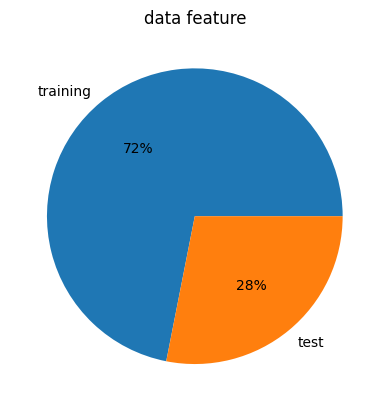

In [ ]:
plt.pie(x = data2["data"].value_counts().reset_index()["data"],
        labels = data2["data"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("data feature")
plt.show()

* 72% Data is used for Training
* 28% Data is used for Test

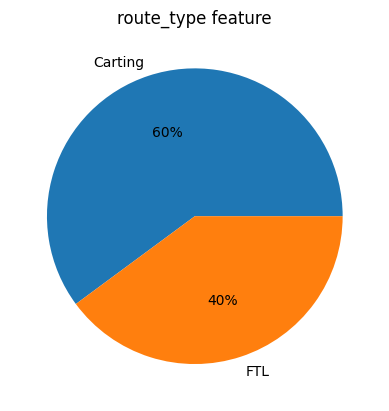

In [ ]:
plt.pie(x = data2["route_type"].value_counts().reset_index()["route_type"],
        labels = data2["route_type"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("route_type feature")
plt.show()

* 60% Trips are of Cart type
* 40% Trips are of FTL type

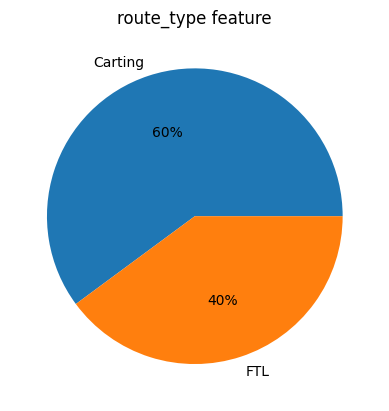

In [ ]:
plt.pie(x = data2["route_type"].value_counts().reset_index()["route_type"],
        labels = data2["route_type"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("route_type feature")
plt.show()

<Axes: xlabel='trip_creation_hour', ylabel='count'>

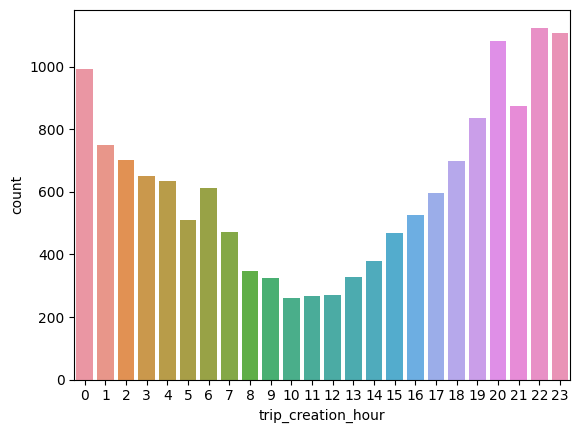

In [ ]:
sns.countplot(data=data2, x= "trip_creation_hour")

* Trip creations are lowest in the Noon and Starts to increase and reaches peak in  midnight

<Axes: xlabel='trip_creation_day', ylabel='count'>

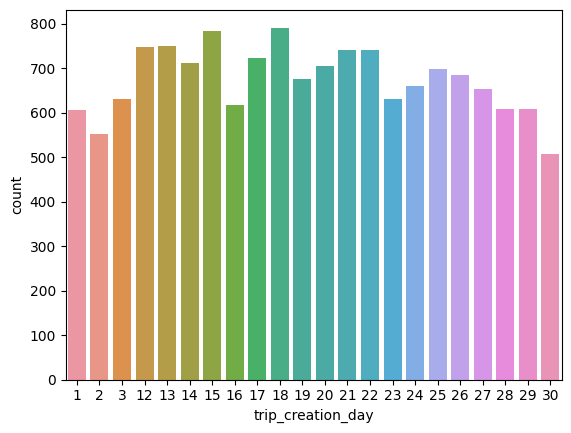

In [ ]:
sns.countplot(data=data2, x= "trip_creation_day")

* More Number of Trip are created in the moiddle of the month and Number of trips are less at start and End of month

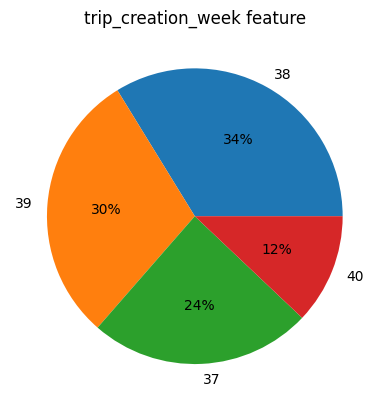

In [ ]:
plt.pie(x = data2["trip_creation_week"].value_counts().reset_index()["trip_creation_week"],
        labels = data2["trip_creation_week"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("trip_creation_week feature")
plt.show()

* There is not much effect of Week ina month for trip Creation

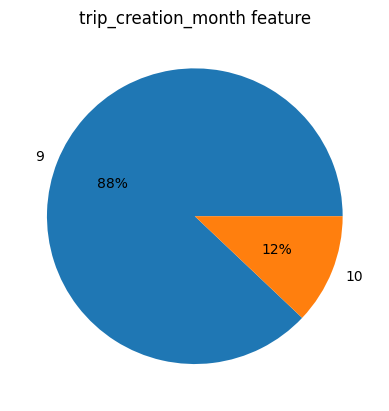

In [ ]:
plt.pie(x = data2["trip_creation_month"].value_counts().reset_index()["trip_creation_month"],
        labels = data2["trip_creation_month"].value_counts().reset_index()["index"],
        autopct='%.0f%%')
plt.title("trip_creation_month feature")
plt.show()

Text(0.5, 1.0, 'Source_State Feature')

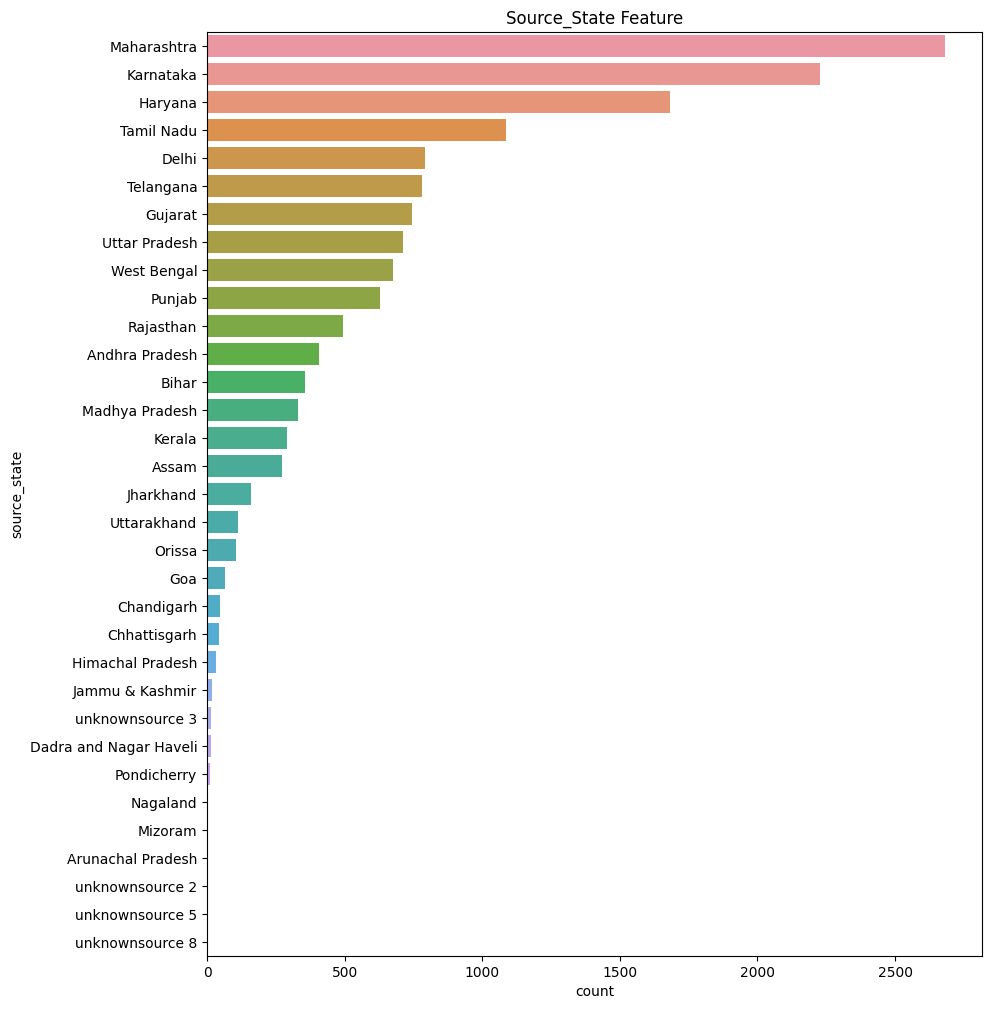

In [ ]:
plt.figure(figsize =(10,12))
sns.countplot(data=data2, y= "source_state",order=data2['source_state'].value_counts().index)
plt.title("Source_State Feature")

Top5 Source States:
* Maharastra
* Karnataka
* Harayana
* Tamilnadu
* Delhi

Text(0.5, 1.0, 'destination_state Feature')

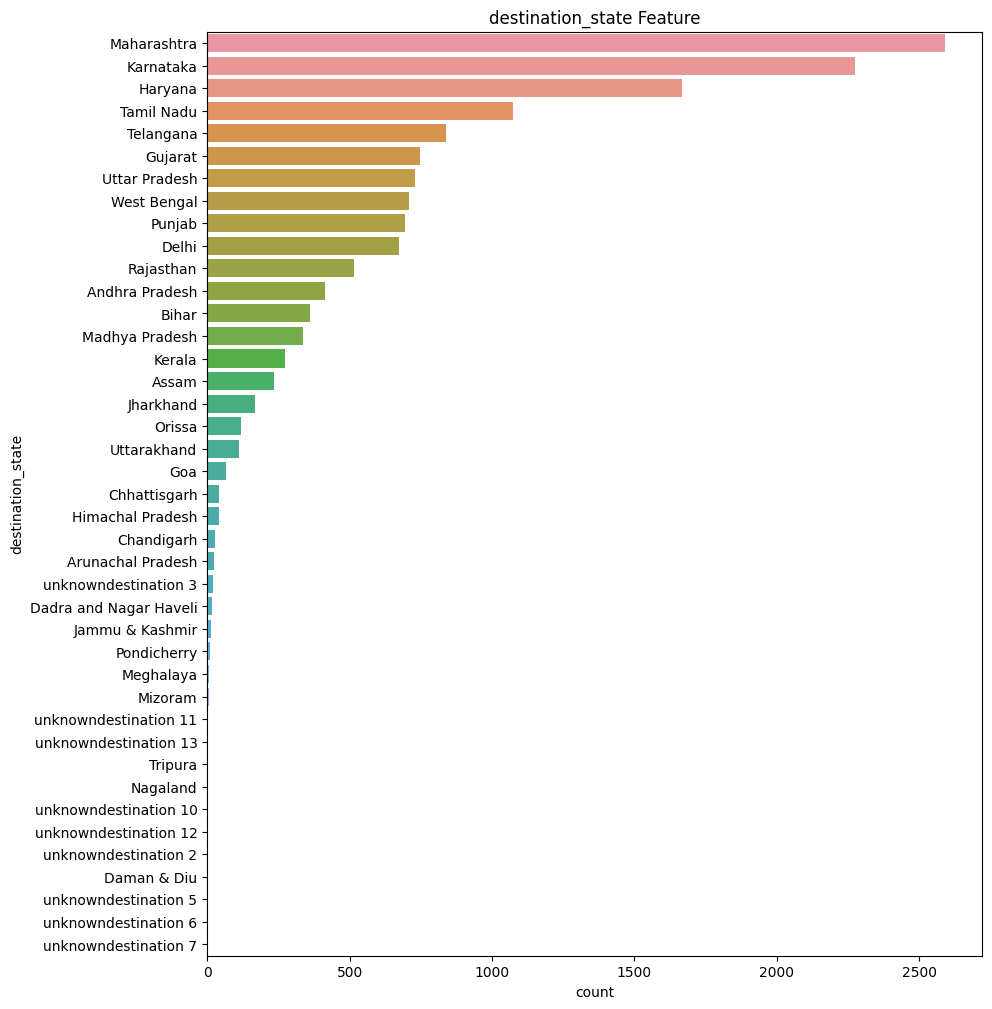

In [ ]:
plt.figure(figsize =(10,12))
sns.countplot(data=data2, y= "destination_state",order=data2['destination_state'].value_counts().index)
plt.title("destination_state Feature")

Top5 destination States:
* Maharastra
* Karnataka
* Harayana
* Tamilnadu
* Telangana

Text(0.5, 1.0, 'source_city Feature')

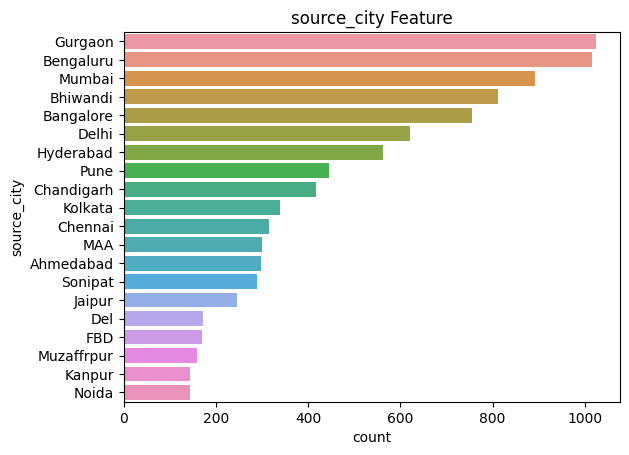

In [ ]:
sns.countplot(data=data2, y= "source_city",order=data2['source_city'].value_counts().index[:20])
plt.title("source_city Feature")

Top5 Source Cities:
* Bengaluru
* Gurgoan
* Mumbai
* Bhiwandi
* Delhi

Text(0.5, 1.0, 'destination_city Feature')

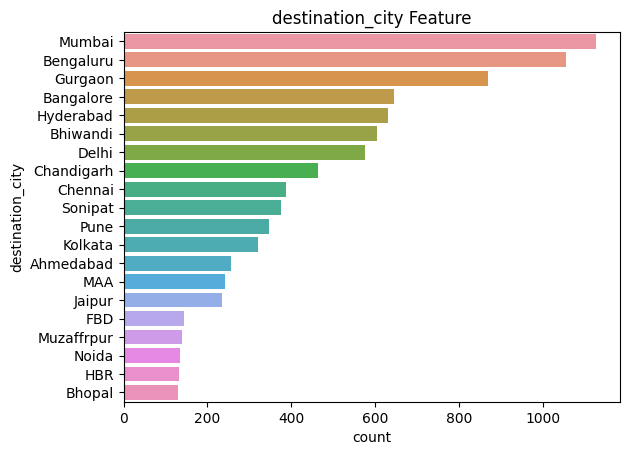

In [ ]:
sns.countplot(data=data2, y= "destination_city",order=data2['destination_city'].value_counts().index[:20])
plt.title("destination_city Feature")

Top5 Destination Cities:
* Bengaluru
* Mumbai
* Gurgoan
* Hyderabad
* Bhiwandi

Text(0.5, 1.0, 'source_place Feature')

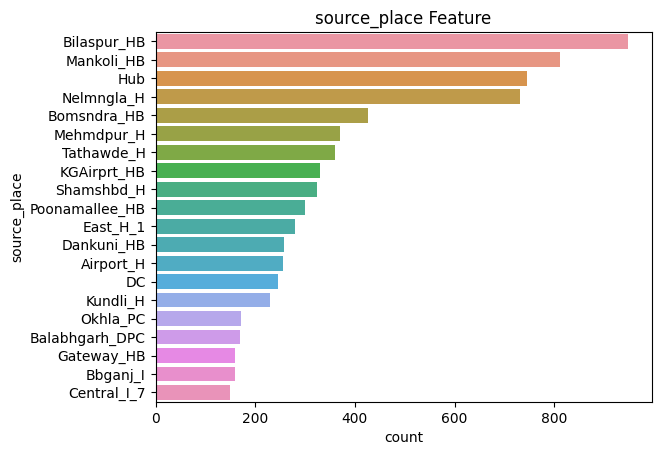

In [ ]:
sns.countplot(data=data2, y= "source_place",order=data2['source_place'].value_counts().index[:20])
plt.title("source_place Feature")

Text(0.5, 1.0, 'destination_place Feature')

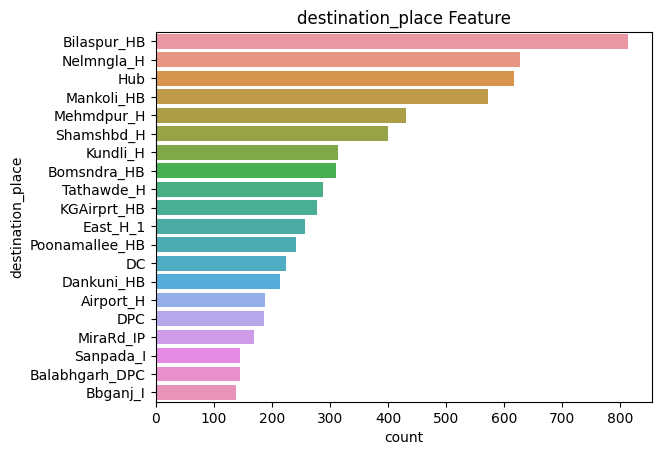

In [ ]:
sns.countplot(data=data2, y= "destination_place",order=data2['destination_place'].value_counts().index[:20])
plt.title("destination_place Feature")

Text(0.5, 0, 'time')

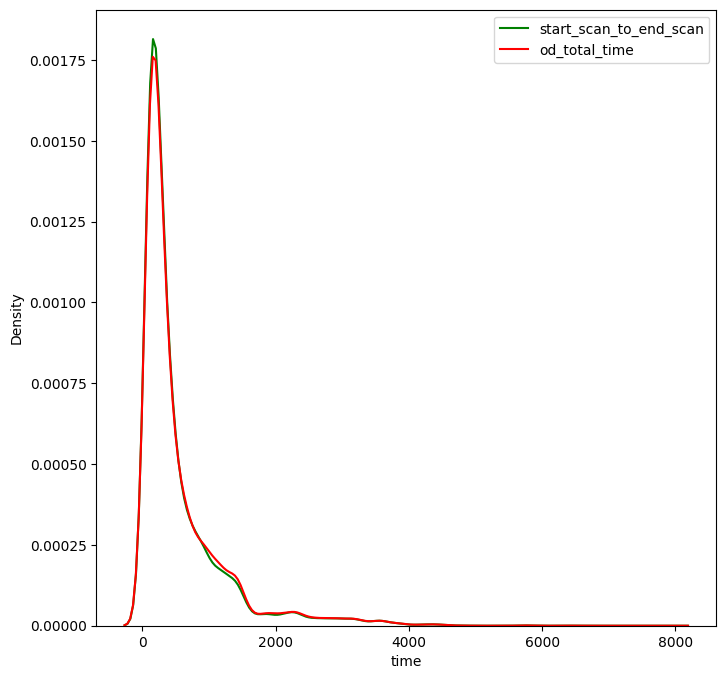

In [ ]:
plt.figure(figsize =(8,8))
sns.kdeplot(data=data2,x = "start_scan_to_end_scan", color = "green")
sns.kdeplot(data=data2,x= "od_total_time",color = "red")
plt.legend(["start_scan_to_end_scan","od_total_time"])
plt.xlabel("time")

* od_total_time & start_scan_to_end_scan almost look like similar
* Further we will perform Hypothesis Testing to conclude

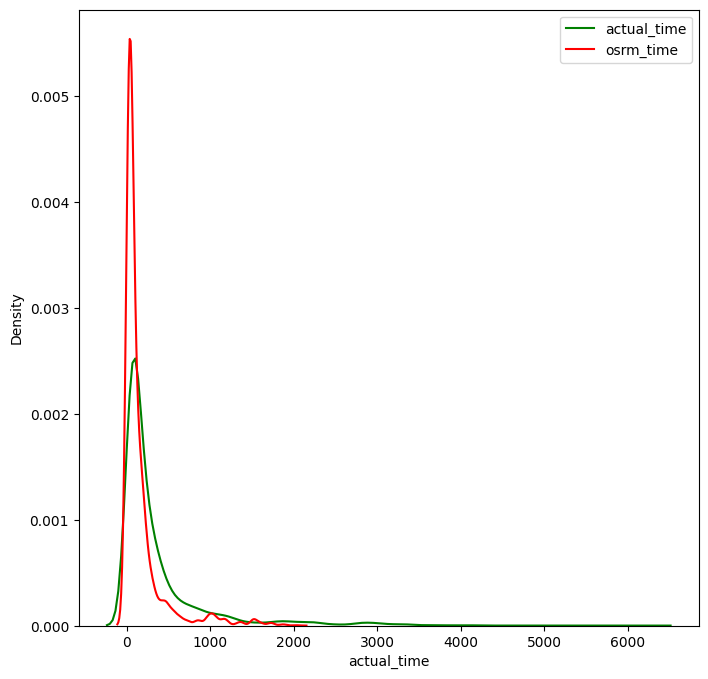

In [ ]:
plt.figure(figsize =(8,8))
sns.kdeplot(data=data2,x = "actual_time",color="green")
sns.kdeplot(data=data2,x= "osrm_time",color = "red")
plt.legend(["actual_time","osrm_time"])

* Actual_time is seems to lower than osrm_time
* Further we will perform Hypothesis Testing to conclude

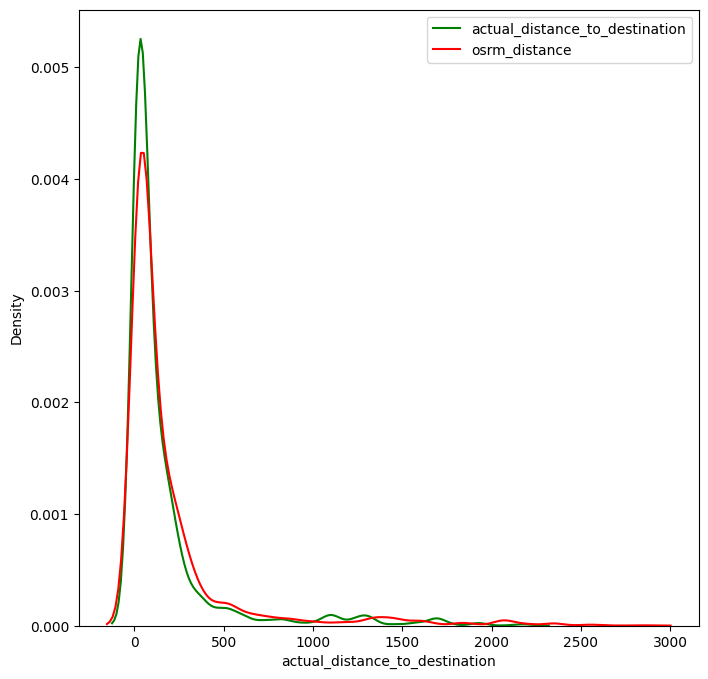

In [ ]:
plt.figure(figsize =(8,8))
sns.kdeplot(data=data2,x = "actual_distance_to_destination",color ="green")
sns.kdeplot(data=data2,x= "osrm_distance",color = "red")
plt.legend(["actual_distance_to_destination","osrm_distance"])

* Actual_distance_to_destination seems to be  greater than osrm_distance
* Further we will perform Hypothesis Testing to conclude

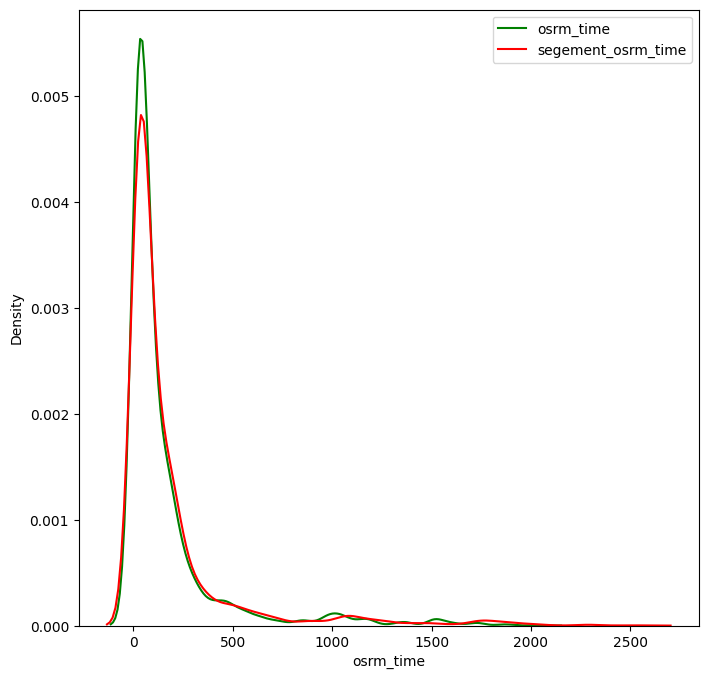

In [ ]:
plt.figure(figsize =(8,8))
sns.kdeplot(data=data2,x = "osrm_time",color = "green")
sns.kdeplot(data=data2,x= "segment_osrm_time",color = "red")
plt.legend(["osrm_time","segement_osrm_time"])

* Total osrm_time seems to be  greater than segment_osrm_time
* Further we will perform Hypothesis Testing to conclude

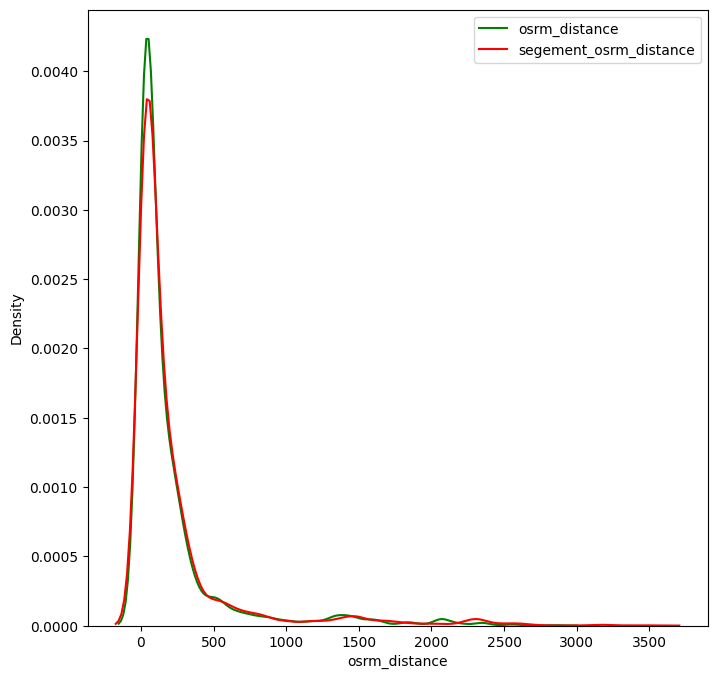

In [ ]:
plt.figure(figsize =(8,8))
sns.kdeplot(data=data2,x = "osrm_distance",color = "green")
sns.kdeplot(data=data2,x= "segment_osrm_distance",color = "red")
plt.legend(["osrm_distance","segement_osrm_distance"])

* Total osrm_distance seems to be  greater than segment_osrm_distacne
* Further we will perform Hypothesis Testing to conclude

<ipython-input-85-9214ab8145cd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data2.corr(),annot=True)


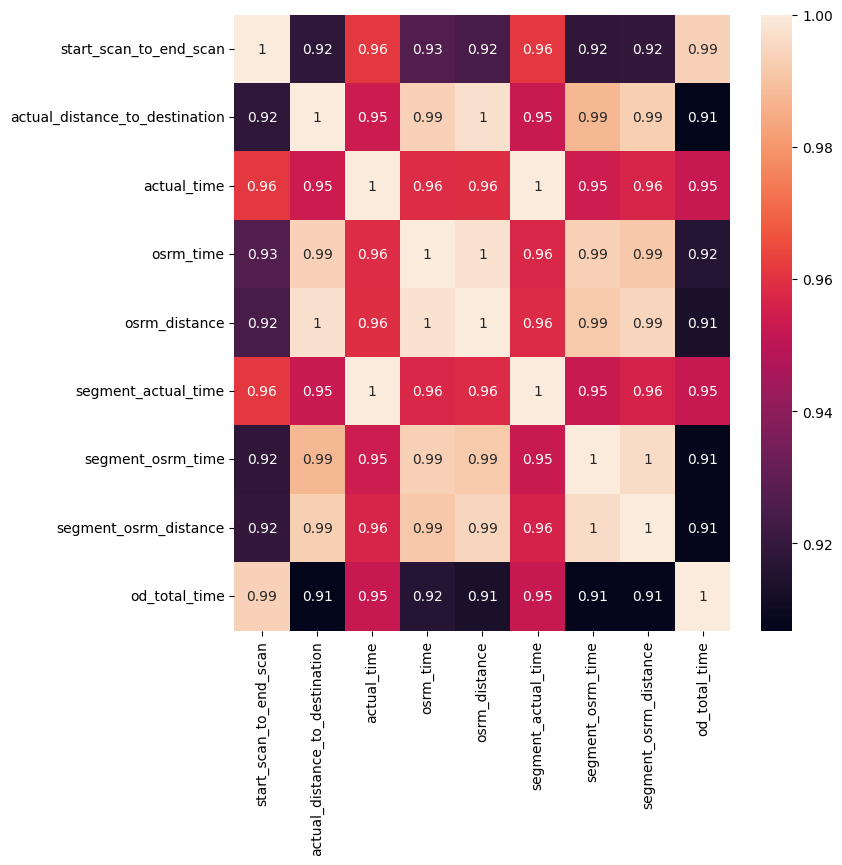

In [ ]:
plt.figure(figsize =(8,8))
sns.heatmap(data2.corr(),annot=True)
plt.show()

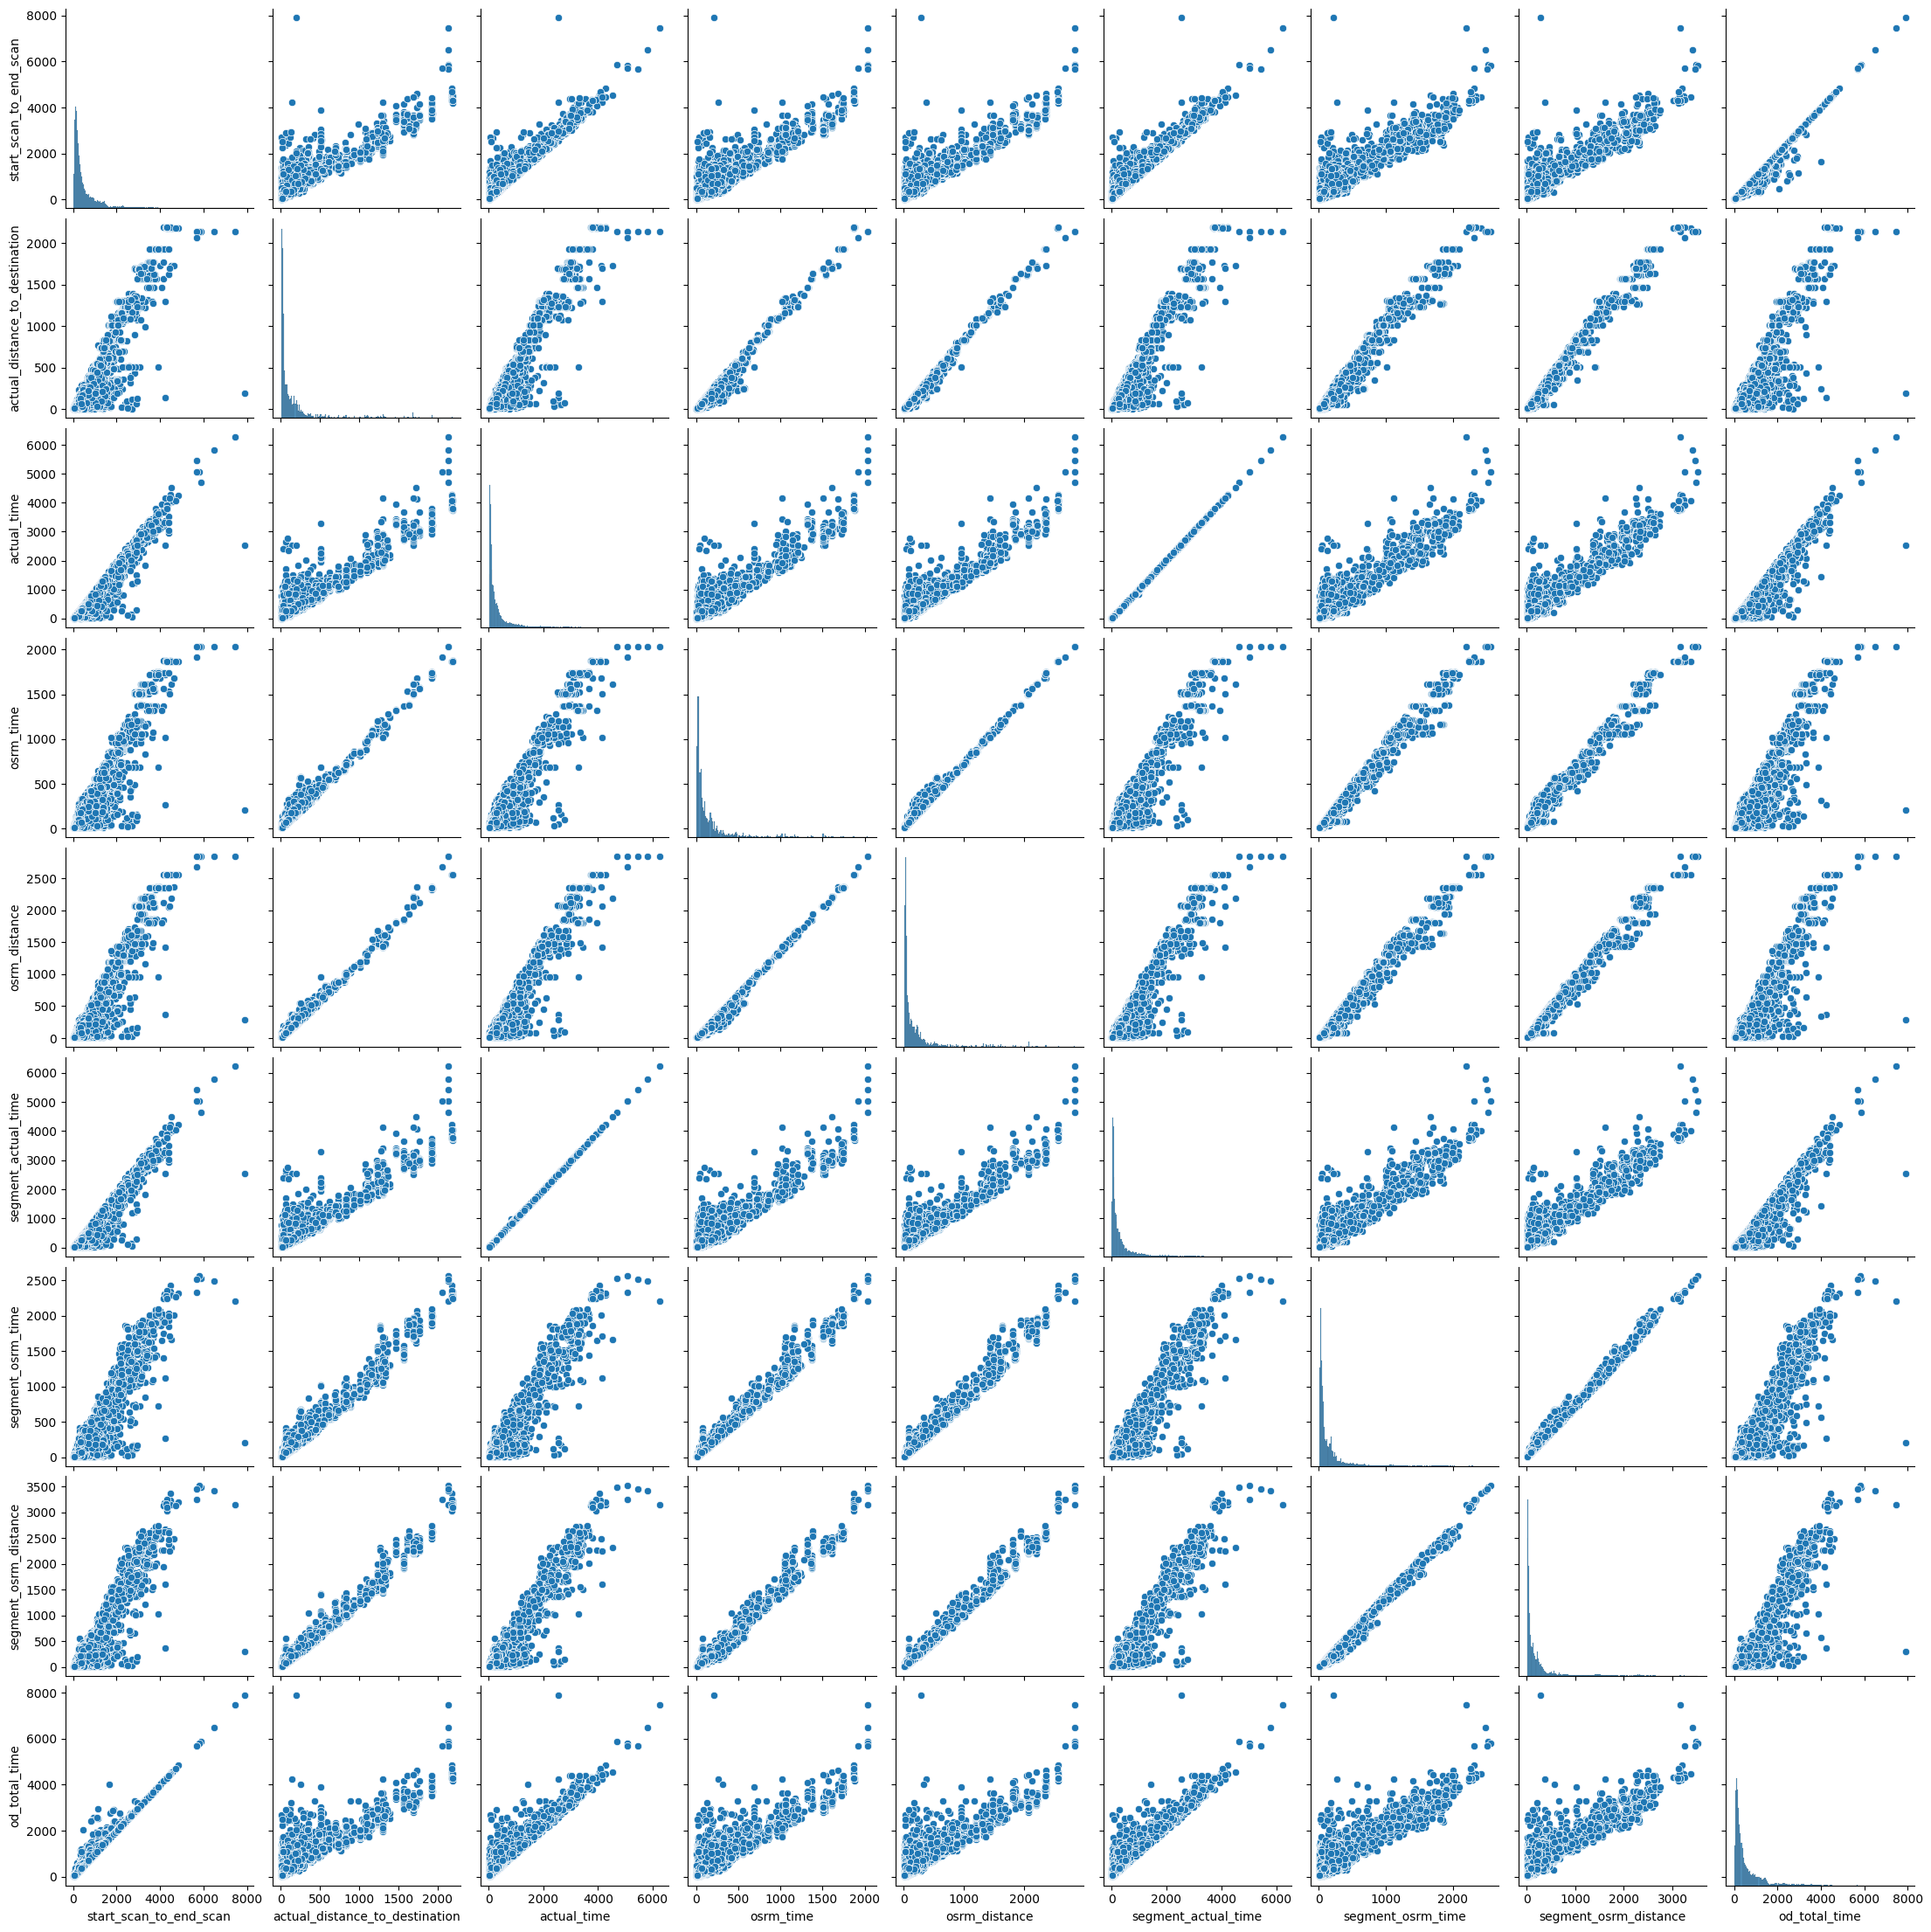

In [ ]:
sns.pairplot(data=data2)

* All Time & Distance Feature are very highly correlated

# **Finding & Treating Outliers Using IQR**

In [ ]:
numericalfeatures = ["start_scan_to_end_scan","od_total_time","actual_distance_to_destination","actual_time","segment_actual_time", "osrm_time",
 "osrm_distance","segment_osrm_time","segment_osrm_distance"]

## IQR Analysis and Outlier Finding

* We will create a new Dataframe " outlier" which store Boolean value of IQR Analysis Result for each reading of all numerical feature columns

In [ ]:
# Finding outlier for all Numerical features
outlier = pd.DataFrame() # creating as new dataframe to store outliers for each numerical feature
for z in numericalfeatures:
    print(z,"Feature")
    print("*******************************************************************")
    IQR = np.percentile(data2[z],75) - np.percentile(data2[z],25)
    lower_limit = max (np.percentile(data2[z],25) - 1.5*IQR,0)
    upper_limit = np.percentile(data2[z],75) + 1.5*IQR
    outlier[z] = (data2[z]>upper_limit) | (data2[z]<lower_limit)

    print("Minimum -->",data2[z].min())
    print("Lower Limit -->",lower_limit)
    print("Quantile25 -->",np.percentile(data2[z],25))
    print("Median -->",np.percentile(data2[z],50))
    print("Quantile75 -->",np.percentile(data2[z],75))
    print("Upper Limit -->",upper_limit)
    print("Maximum -->",data2[z].max())

    print()
    print("Out of ",len(data2[z]), "Data points , There are",outlier[z].sum(),"Outliers")
    print("Percentage of Outliers:",np.round((outlier[z].sum()/len(data2[z])*100),2),"%")
    print()
    print("*******************************************************************")

start_scan_to_end_scan Feature
*******************************************************************
Minimum --> 23.0
Lower Limit --> 0
Quantile25 --> 149.0
Median --> 280.0
Quantile75 --> 637.0
Upper Limit --> 1369.0
Maximum --> 7898.0

Out of  14817 Data points , There are 1267 Outliers
Percentage of Outliers: 8.55 %

*******************************************************************
od_total_time Feature
*******************************************************************
Minimum --> 23.461468483333334
Lower Limit --> 0
Quantile25 --> 151.15848843333333
Median --> 288.5703387
Quantile75 --> 673.3013645
Upper Limit --> 1456.5156785999998
Maximum --> 7898.551954566667

Out of  14817 Data points , There are 1115 Outliers
Percentage of Outliers: 7.53 %

*******************************************************************
actual_distance_to_destination Feature
*******************************************************************
Minimum --> 9.00246144174878
Lower Limit --> 0
Quantile25 --> 22

In [ ]:
# Finding outlier for all Numerical features
# In this we are not creating a exlusive DataFrame to Store , just find & print the index of Outliers
for z in numericalfeatures:
    outlierlist=[]
    print(z,"Feature")
    print("*******************************************************************")
    IQR = np.percentile(data2[z],75) - np.percentile(data2[z],25)
    lower_limit = max (np.percentile(data2[z],25) - 1.5*IQR,0)
    upper_limit = np.percentile(data2[z],75) + 1.5*IQR
    outlierlist.extend(list(np.where( (data2[z]>upper_limit) | (data2[z]<lower_limit) )[0]))

    print("Minimum -->",data2[z].min())
    print("Lower Limit -->",lower_limit)
    print("Quantile25 -->",np.percentile(data2[z],25))
    print("Median -->",np.percentile(data2[z],50))
    print("Quantile75 -->",np.percentile(data2[z],75))
    print("Upper Limit -->",upper_limit)
    print("Maximum -->",data2[z].max())

    print(outlierlist)

    print()
    print("Out of ",len(data2[z]), "Data points , There are",len(outlierlist),"Outliers")
    print()
    print("*******************************************************************")

start_scan_to_end_scan Feature
*******************************************************************
Minimum --> 23.0
Lower Limit --> 0
Quantile25 --> 149.0
Median --> 280.0
Quantile75 --> 637.0
Upper Limit --> 1369.0
Maximum --> 7898.0
[0, 2, 41, 43, 62, 72, 75, 77, 78, 81, 112, 115, 134, 183, 189, 190, 220, 228, 237, 264, 271, 327, 330, 342, 348, 358, 363, 365, 378, 380, 383, 386, 410, 411, 416, 421, 439, 447, 468, 479, 491, 492, 518, 520, 526, 528, 549, 575, 581, 583, 585, 627, 635, 641, 647, 666, 667, 670, 675, 684, 685, 749, 781, 805, 821, 823, 828, 836, 841, 888, 894, 918, 923, 925, 926, 934, 939, 944, 957, 961, 979, 1003, 1036, 1037, 1047, 1051, 1060, 1075, 1079, 1096, 1107, 1108, 1127, 1143, 1149, 1161, 1164, 1179, 1181, 1200, 1216, 1221, 1226, 1237, 1244, 1247, 1248, 1249, 1257, 1301, 1372, 1385, 1396, 1417, 1453, 1462, 1467, 1512, 1537, 1540, 1546, 1565, 1572, 1573, 1574, 1592, 1611, 1667, 1668, 1672, 1678, 1736, 1739, 1741, 1765, 1786, 1794, 1803, 1815, 1831, 1849, 1860, 1865,

## Box-Plot for Outlier Visualization

* Let us visualize the outliers with Box plot

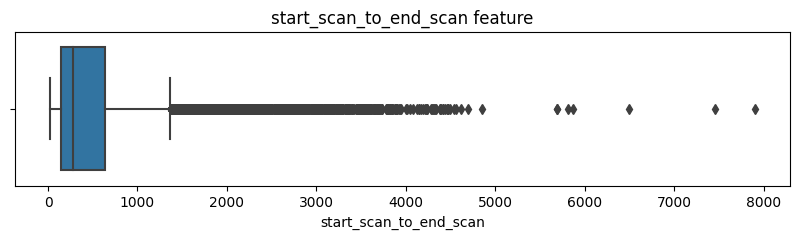

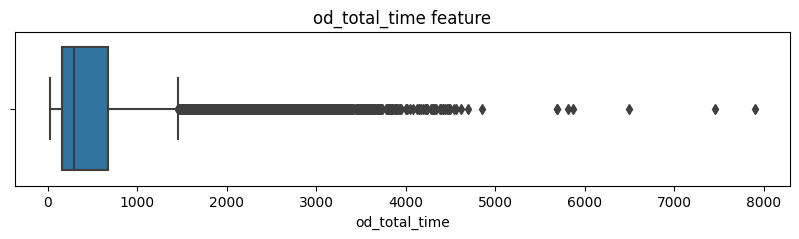

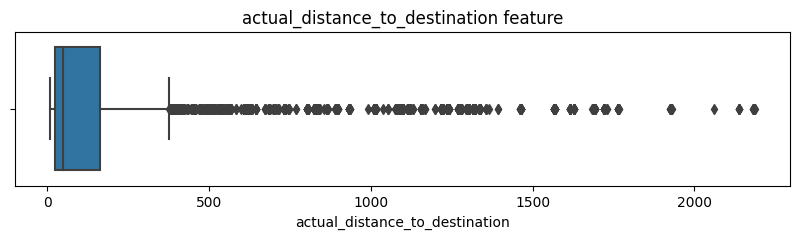

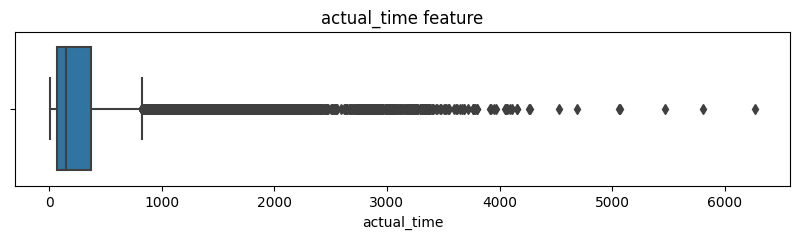

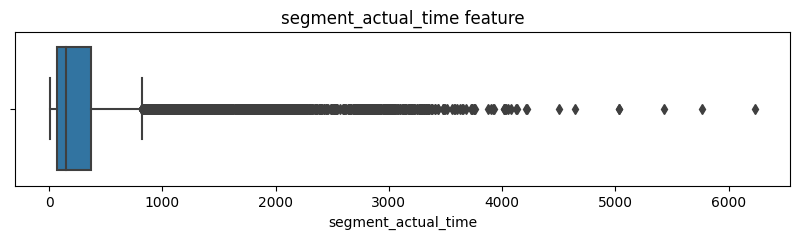

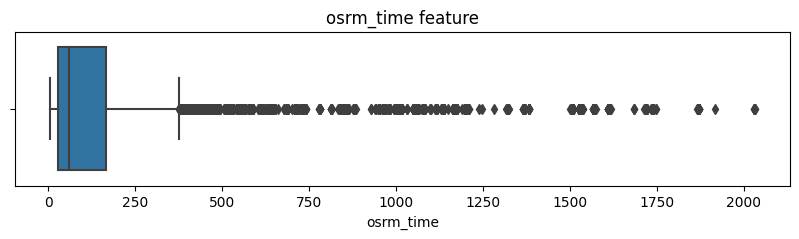

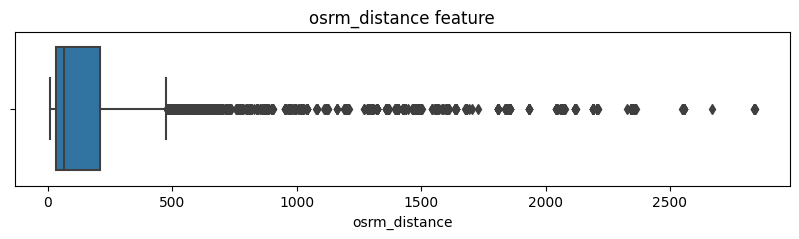

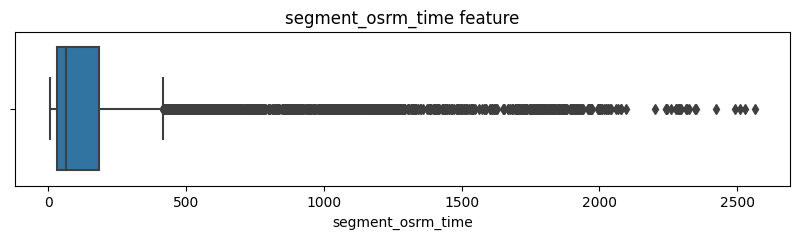

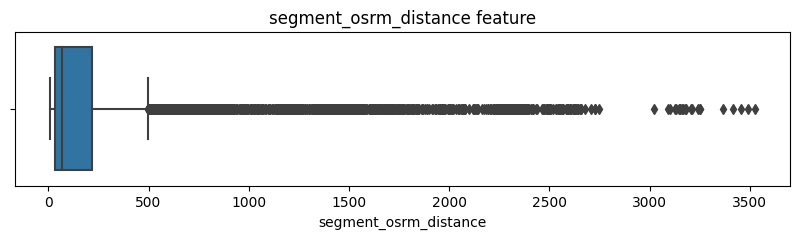

In [ ]:
for z in numericalfeatures:
  plt.figure(figsize=(10,2))
  sns.boxplot(data= data2, x = z)
  plt.title(z+" feature")

## Outlier Treatment

* let us check if outliers are really outliers or they are occuring due to long distance/ Duration Couriers

In [ ]:
outlier.shape

(14817, 9)

In [ ]:
outlier["count"] = outlier.sum(axis=1)

In [ ]:
# Checking for rows which have come as outliers in all 9 numerical columns
outlier[outlier["count"]==9].count()

start_scan_to_end_scan            943
od_total_time                     943
actual_distance_to_destination    943
actual_time                       943
segment_actual_time               943
osrm_time                         943
osrm_distance                     943
segment_osrm_time                 943
segment_osrm_distance             943
count                             943
dtype: int64

In [ ]:
# Checking for rows which have come as outliers in all 9 numerical columns
data2.iloc[outlier[outlier["count"]==9].index]

trip_uuid      data  \
0      trip-153671041653548748  training   
2      trip-153671043369099517  training   
41     trip-153671321710455800  training   
43     trip-153671328307356992  training   
62     trip-153671547254076660  training   
...                        ...       ...   
14701  trip-153860352246282031      test   
14730  trip-153860570045461434      test   
14750  trip-153860698042160875      test   
14769  trip-153860879439383883      test   
14795  trip-153861014185597051      test   

                                     route_schedule_uuid route_type  \
0      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
2      thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
41     thanos::sroute:951d77aa-4725-4c4e-882d-42acc35...        FTL   
43     thanos::sroute:64d4c6c9-ffb9-4794-b9f1-05f064c...        FTL   
62     thanos::sroute:2a713f58-e06f-4251-a6f0-f374373...        FTL   
...                                                  ...        ...   
14701  thanos::sroute:be1c03eb-fd2f-4455-a933-5e3d085...        FTL   
14730  thanos::sroute:870bead8-6c8a-458f-b4d8-658de44...        FTL   
14750  thanos::sroute:67c77992-49e3-4594-9a75-9861ef0...        FTL   
14769  thanos::sroute:105d3425-e2d7-4f05-ad0c-157dc94...        FTL   
14795  thanos::sroute:fb308c0f-ea3a-48ef-a6c3-4776341...        FTL   

              trip_creation_time                         source_name  \
0     2018-09-12 00:00:16.535741  Bhopal_Trnsport_H (Madhya Pradesh)   
2     2018-09-12 00:00:33.691250    Bangalore_Nelmngla_H (Karnataka)   
41    2018-09-12 00:46:57.104787   Bhiwandi_Mankoli_HB (Maharashtra)   
43    2018-09-12 00:48:03.073766             Delhi_Airport_H (Delhi)   
62    2018-09-12 01:24:32.541032    Hyderabad_Shamshbd_H (Telangana)   
...                          ...                                 ...   
14701 2018-10-03 21:52:02.463089       Gurgaon_Bilaspur_HB (Haryana)   
14730 2018-10-03 22:28:20.454881       Gurgaon_Bilaspur_HB (Haryana)   
14750 2018-10-03 22:49:40.421862   Bhiwandi_Mankoli_HB (Maharashtra)   
14769 2018-10-03 23:19:54.394130    Bangalore_Nelmngla_H (Karnataka)   
14795 2018-10-03 23:42:21.856227  Bhopal_Trnsport_H (Madhya Pradesh)   

      source_center                   destination_name destination_center  \
0      IND462022AAA      Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   
2      IND562132AAA     Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
41     IND421302AAG      Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   
43     IND110037AAM  Bhiwandi_Mankoli_HB (Maharashtra)       IND421302AAG   
62     IND501359AAE   Hyderabad_Shamshbd_H (Telangana)       IND501359AAE   
...             ...                                ...                ...   
14701  IND000000ACB   Kolkata_Dankuni_HB (West Bengal)       IND712311AAA   
14730  IND000000ACB             Ranchi_Hub (Jharkhand)       IND834002AAB   
14750  IND421302AAG     Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
14769  IND562132AAA     Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
14795  IND462022AAA      Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   

       start_scan_to_end_scan  ...  trip_creation_day  trip_creation_week  \
0                      2259.0  ...                 12                  37   
2                      3933.0  ...                 12                  37   
41                     2338.0  ...                 12                  37   
43                     2302.0  ...                 12                  37   
62                     1792.0  ...                 12                  37   
...                       ...  ...                ...                 ...   
14701                  2114.0  ...                  3                  40   
14730                  2051.0  ...                  3                  40   
14750                  2660.0  ...                  3                  40   
14769                  4410.0  ...                  3                  40   
14

* There are total 943 Rows which have come as outlier in all 9 numerical features
* **But we cannot delete the rows just because of the IQR rule, these outliers might be trips which are having very long distance & duration**
* So all t**hese outliers can be good Data points** only
* so we cannot drop these outliers data point
* we will use them as OK


# **Hypothesis Testing**

* In this Data Differet test [Num-Num,Cat-Num,Cat-Cat] can be done
* But our objective to increase the end user experince by correctly predicting Duration of Delivery & for optimizing Logistics by correctly predicting distance w.r.t OSRM Distance & Duration
* Also we have to optimize Each Segment wise for each trip
* so we will do Hypothesis testing for below combinations
** od_total_time and start_scan_to_end_scan
** actual_time and osrm_time
** actual_time and segment_actual_time
** osrm_distance and segment_osrm_distance
** osrm_time and segment_osrm_time
** actual_distance_to_destination and osrm_distance





## Hypothesis Testing Set up

In this section let us fix the Confidence level & Level of Signification for all our Hypothesis testing.

As this is with respect to predicting demand Situation
* let us Assume **we want 95% Confidence to reject Null Hypothesi**s
* so for every Hypothesis testing, **Level of Significane will be "0.05 "**

As we have 2 Nos of Cat-Num, we will use 2 Sample T-Test or its equivalent
* Ho --> Both Categories have same Mean
* Ha --> Both Categories have different mean

Before using T-test , we will c**heck for assumptions if both Data sample means are following Normal Distribution? & does they have equal variance**?

* For **Sample means should follow Normal Distribution**, we will use Shapiro test with below Hypothesis Condition
** H0 : Data is Gaussian
** Ha : Data is not Gaussian

* For **Equal Variances** Check, we will use Levene Test with below Hypothesis condition
** H0: Variances are equal
** Ha: Variances are not equal




## od_total_time and start_scan_to_end_scan

In [ ]:
subset = ["od_total_time","start_scan_to_end_scan"]

In [ ]:
subsetsamplemean = [[np.mean(data2[i].sample(500)) for k in range(5000)] for i in subset]

* let's check for Normal Distribution of both Data sets Sample Mean

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in range(2):
  test_stat, p_value = shapiro(subsetsamplemean[i])
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(subset[i],"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(subset[i],"Data is Gaussian")
  print()

1.3234453945187852e-05
Reject H0
od_total_time Data is Not Gaussian

0.006467732600867748
Reject H0
start_scan_to_end_scan Data is Not Gaussian



* Let us plot Histplot to check how data actually looks

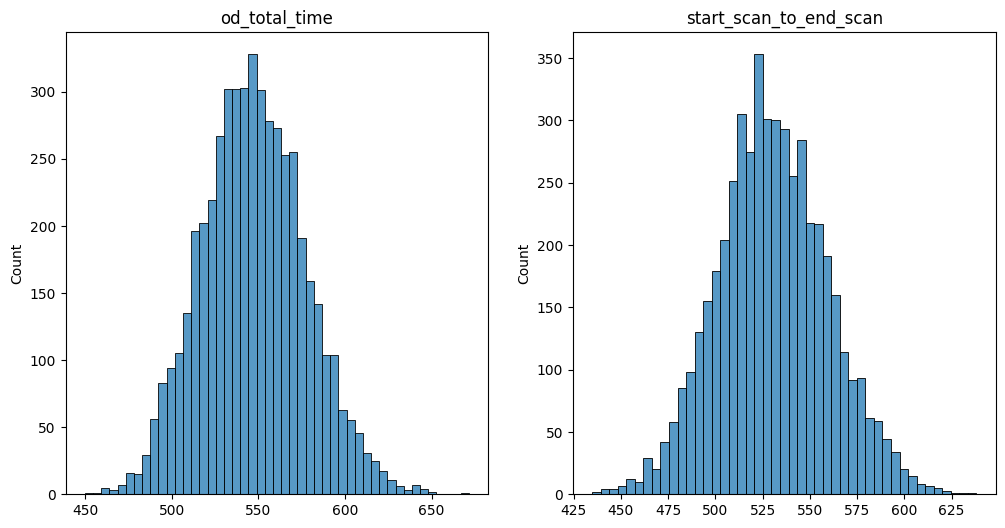

In [ ]:
plt.figure(figsize = (12,6))
for i in range(2):
  plt.subplot(1,2,i+1)
  sns.histplot(subsetsamplemean[i])
  plt.title(subset[i])
plt.show()

* Even the Histogram shows that they are not following Normal Distribution
* Let's do QQ Plot also

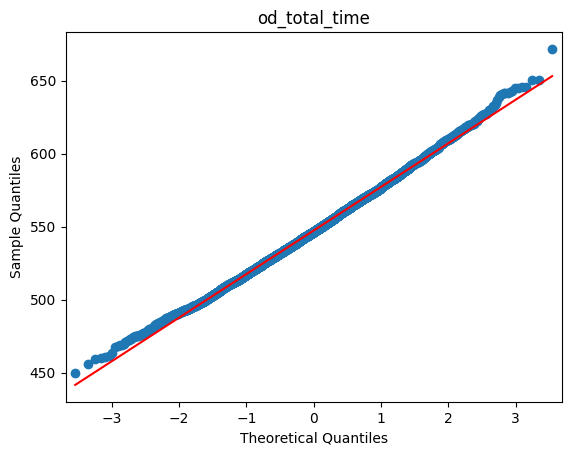

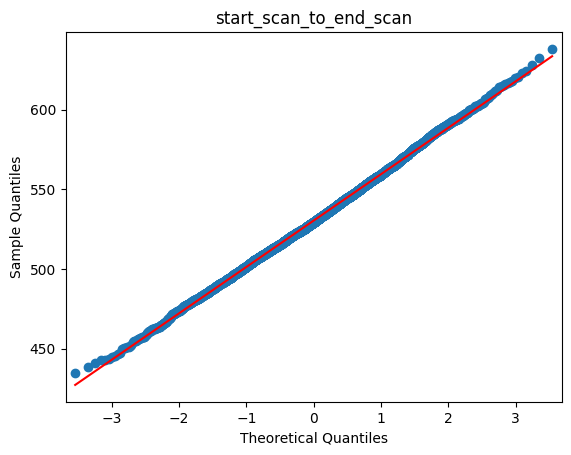

In [ ]:
for i in range(2):
   qqplot( np.array(subsetsamplemean[i]) , line="s")
   plt.title(subset[i])
   plt.show()

* From Shapiro, Histogram & QQ plot--> we can conclude that both data sets sample means are not following Normal Distribution, slightly deviated
* Now we will do Levene test to check for equal Variances of datasets

In [ ]:
# Ho: Variances are equal
# Ha: Variances are not equal
levene_stat, p_value = levene(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to reject Ho")
    print("Variances are equal")

0.04528721781238512
Reject Ho
Variances are not equal


* Both Datasets do not have equal Variance
* T-Test Independent is valid on the assumptions that 1. Sample means of 2 data sets follow Normal Distribution & Datasets Have Equal Variances
* But both of them are not valid
* so we will **Non-Paramteric Independent sample T-test**

In [ ]:
# subset = ["od_total_time","start_scan_to_end_scan"]

#H0: mu1 <= mu2
#Ha : mu1 > mu2

kruskal_stat, p_value= mannwhitneyu(data2[subset[0]],data2[subset[1]],alternative = "greater")
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("One or more groups have different mean")
else:
    print("Fail to reject H0")
    print("All groups have same mean")

0.010834055922721585
Reject H0
One or more groups have different mean


* From Hypothesis Testing we can conclude that, **"od_total_time" is greater than "start_scan_to_end_scan" for a given trip_uuid**

## actual_time and osrm_time

In [ ]:
subset = ["actual_time","osrm_time"]

In [ ]:
subsetsamplemean = [[np.mean(data2[i].sample(500)) for k in range(5000)] for i in subset]

* let's check for Normal Distribution of both Data sets Sample Mean

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in range(2):
  test_stat, p_value = shapiro(subsetsamplemean[i])
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(subset[i],"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(subset[i],"Data is Gaussian")
  print()

1.142875362347695e-06
Reject H0
actual_time Data is Not Gaussian

3.08930866594892e-05
Reject H0
osrm_time Data is Not Gaussian



* Let us plot Histplot to check how data actually looks

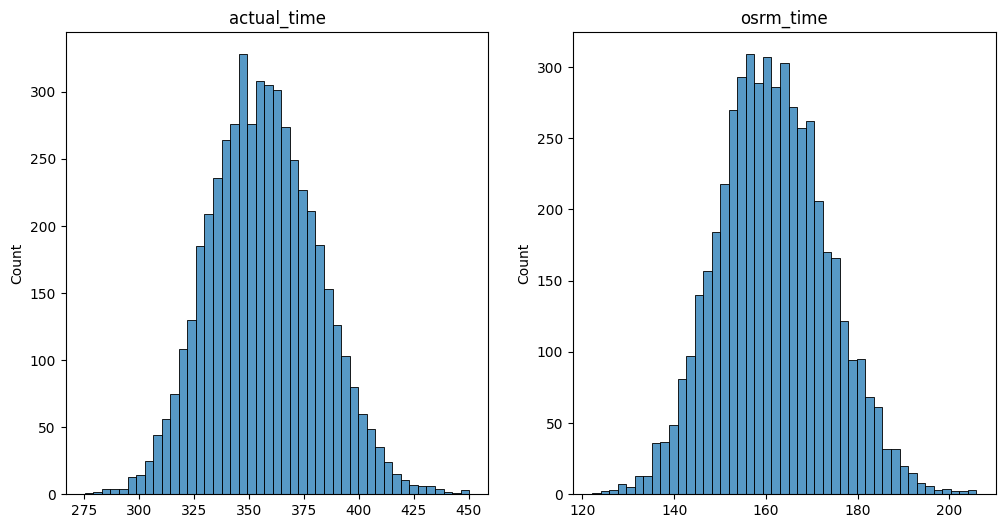

In [ ]:
plt.figure(figsize = (12,6))
for i in range(2):
  plt.subplot(1,2,i+1)
  sns.histplot(subsetsamplemean[i])
  plt.title(subset[i])
plt.show()

* Even the Histogram shows that they are not following Normal Distribution
* Let's do QQ Plot also

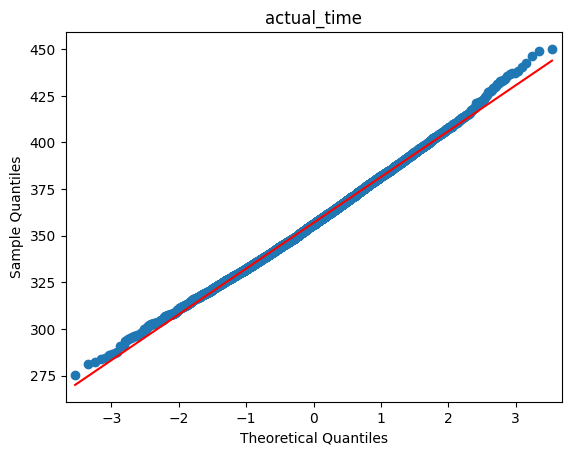

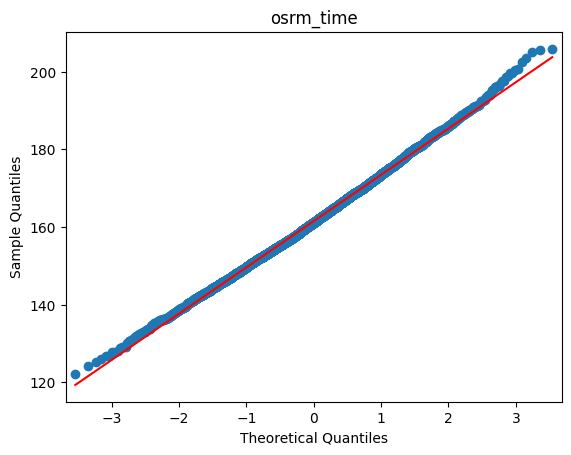

In [ ]:
for i in range(2):
   qqplot( np.array(subsetsamplemean[i]) , line="s")
   plt.title(subset[i])
   plt.show()

* From Shapiro, Histogram & QQ plot--> we can conclude that both data sets sample means are not following Normal Distribution, slightly deviated
* Now we will do Levene test to check for equal Variances of datasets

In [ ]:
# Ho: Variances are equal
# Ha: Variances are not equal
levene_stat, p_value = levene(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to reject Ho")
    print("Variances are equal")

1.871297993683208e-220
Reject Ho
Variances are not equal


* Both Datasets do not have equal Variance
* T-Test Independent is valid on the assumptions that 1. Sample means of 2 data sets follow Normal Distribution & Datasets Have Equal Variances
* But both of them are not valid
* so we will **Non-Paramteric Independent sample T-test**

In [ ]:
# subset = ["actual_time","osrm_time"]

#H0: mu1 <= mu2
#Ha : mu1 > mu2

kruskal_stat, p_value= mannwhitneyu(data2[subset[0]],data2[subset[1]],alternative = "greater")
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("One or more groups have different mean")
else:
    print("Fail to reject H0")
    print("All groups have same mean")

0.0
Reject H0
One or more groups have different mean


* From Hypothesis Testing we can conclude that, **"actual_time" is always greater than "osrm_time" for a given trip_uuid**

## actual_time  and segment_actual_time

In [ ]:
subset = ["actual_time","segment_actual_time"]

In [ ]:
subsetsamplemean = [[np.mean(data2[i].sample(500)) for k in range(5000)] for i in subset]

* let's check for Normal Distribution of both Data set's Sample mean

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in range(2):
  test_stat, p_value = shapiro(subsetsamplemean[i])
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(subset[i],"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(subset[i],"Data is Gaussian")
  print()

4.538553000088541e-08
Reject H0
actual_time Data is Not Gaussian

0.0002473114291206002
Reject H0
segment_actual_time Data is Not Gaussian



* Let us plot Histplot to check how data actually looks

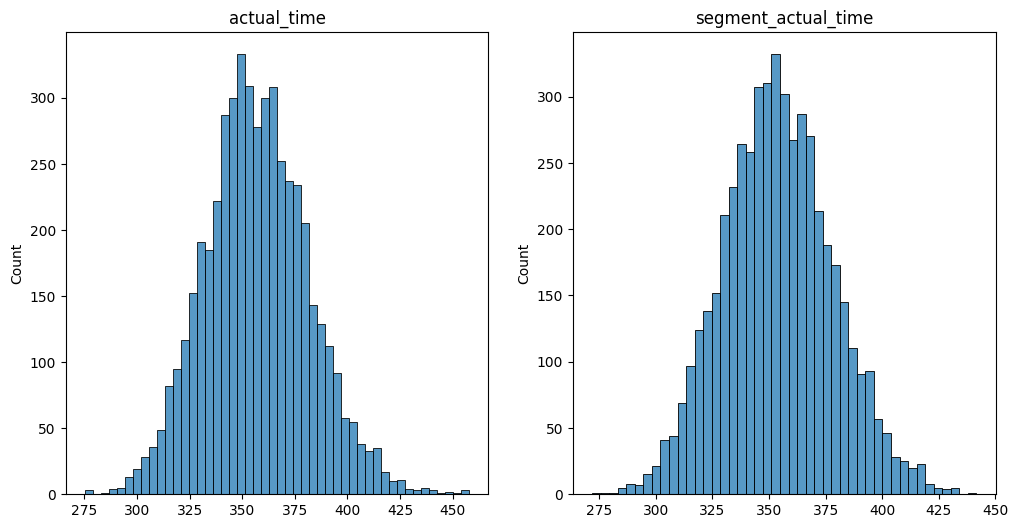

In [ ]:
plt.figure(figsize = (12,6))
for i in range(2):
  plt.subplot(1,2,i+1)
  sns.histplot(subsetsamplemean[i])
  plt.title(subset[i])
plt.show()

* Even the Histogram shows that they are not following Normal Distribution
* Let's do QQ Plot also

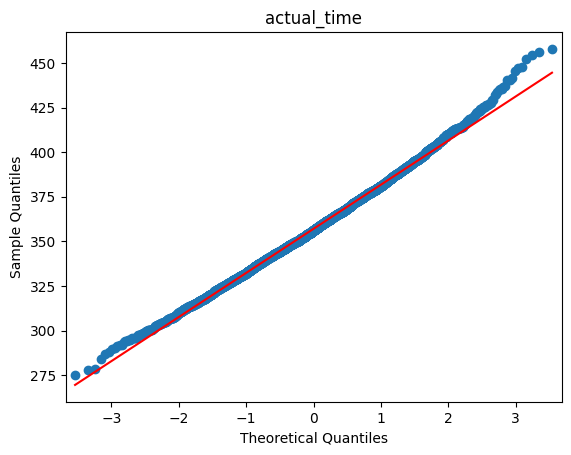

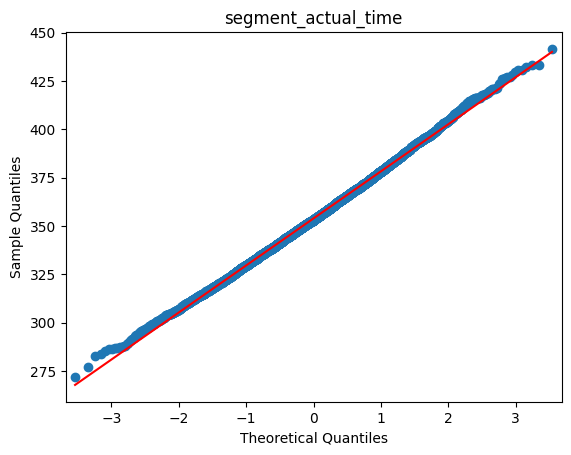

In [ ]:
for i in range(2):
   qqplot( np.array(subsetsamplemean[i]) , line="s")
   plt.title(subset[i])
   plt.show()

* From Shapiro, Histogram & QQ plot--> we can conclude that both data sets sample means are not following Normal Distribution, slightly deviated
* Now we will do Levene test to check for equal Variances of datasets

In [ ]:
# Ho: Variances are equal
# Ha: Variances are not equal
levene_stat, p_value = levene(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to reject Ho")
    print("Variances are equal")

0.6955022668700895
Fail to reject Ho
Variances are equal


* Both Datasets do not have equal Variance
* T-Test Independent is valid on the assumptions that 1. Sample means of 2 data sets follow Normal Distribution & Datasets Have Equal Variances
* But only Equal Variance Assumption is satisfying
* so we will **Non-Paramteric Independent sample T-test**

In [ ]:
# subset = ["actual_time","segment_actual_time"]

# H0: mu1 = mu2
#Ha: mu1 != mu2

kruskal_stat, p_value= mannwhitneyu(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("One or more groups have different mean")
else:
    print("Fail to reject H0")
    print("All groups have same mean")

0.4164235159622476
Fail to reject H0
All groups have same mean


* From Hypothesis Testing we can conclude that, **"actual_time" & "segment_actual_time" have approx same mean for a given trip_uuid **

## osrm_distance and segment_osrm_distance

In [ ]:
subset = ["osrm_distance","segment_osrm_distance"]

In [ ]:
subsetsamplemean = [[np.mean(data2[i].sample(500)) for k in range(5000)] for i in subset]

* let's check for Normal Distribution of both Data sets Mean

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in range(2):
  test_stat, p_value = shapiro(subsetsamplemean[i])
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(subset[i],"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(subset[i],"Data is Gaussian")
  print()

3.2689862564438954e-05
Reject H0
osrm_distance Data is Not Gaussian

0.530376672744751
Fail to reject H0
segment_osrm_distance Data is Gaussian



* Let us plot Histplot to check how data actually looks

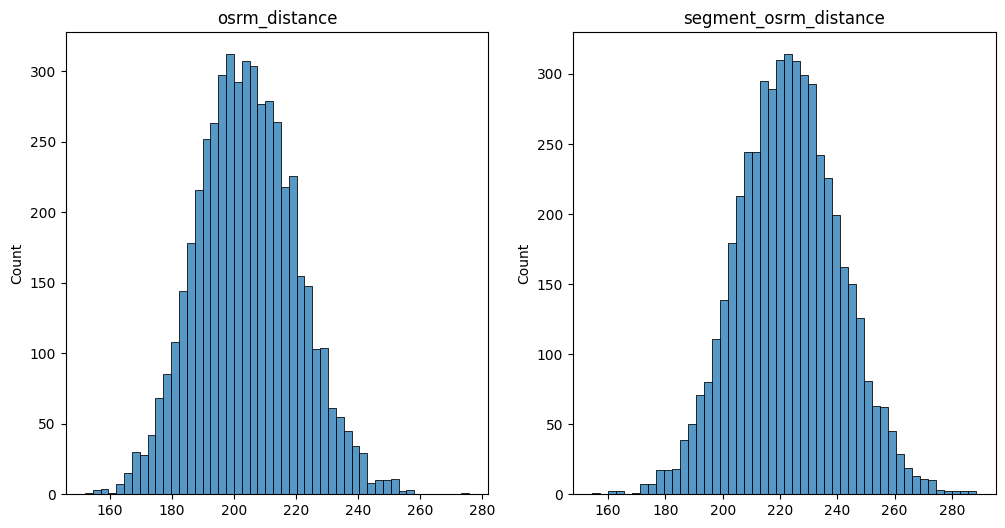

In [ ]:
plt.figure(figsize = (12,6))
for i in range(2):
  plt.subplot(1,2,i+1)
  sns.histplot(subsetsamplemean[i])
  plt.title(subset[i])
plt.show()

* Even the Histogram shows that they are not following Normal Distribution
* Let's do QQ Plot also

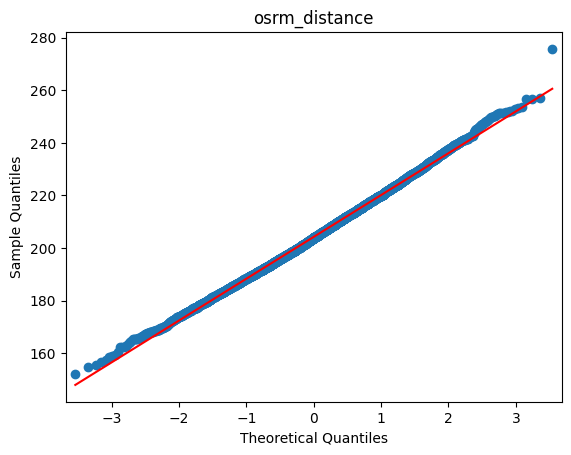

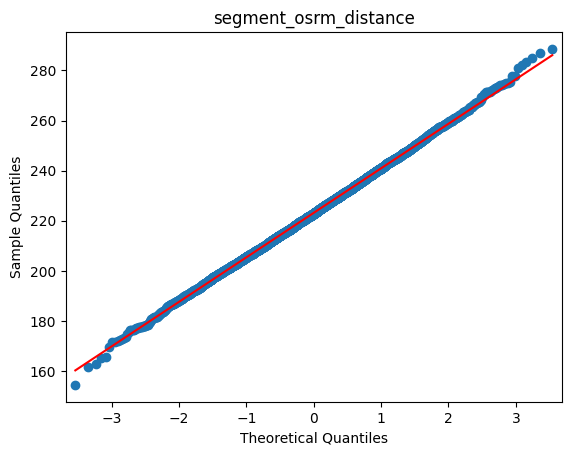

In [ ]:
for i in range(2):
   qqplot( np.array(subsetsamplemean[i]) , line="s")
   plt.title(subset[i])
   plt.show()

* From Shapiro, Histogram & QQ plot--> we can conclude that both data sets sample means are not following Normal Distribution, slightly deviated
* Now we will do Levene test to check for equal Variances of datasets

In [ ]:
# Ho: Variances are equal
# Ha: Variances are not equal
levene_stat, p_value = levene(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to reject Ho")
    print("Variances are equal")

0.00020976354422600578
Reject Ho
Variances are not equal


* Both Datasets do not have equal Variance
* T-Test Independent is valid on the assumptions that 1. Sample means of 2 data sets follow Normal Distribution & Datasets Have Equal Variances
* But both of them are not valid
* so we will **Non-Paramteric Independent sample T-test**

In [ ]:
# subset = ["osrm_distance","segment_osrm_distance"]

#H0: mu1 >= mu2
#Ha : mu1 < mu2

kruskal_stat, p_value= mannwhitneyu(data2[subset[0]],data2[subset[1]],alternative = "less")
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("One or more groups have different mean")
else:
    print("Fail to reject H0")
    print("All groups have same mean")

4.755626029197483e-07
Reject H0
One or more groups have different mean


* From Hypothesis Testing we can conclude that, **"osrm_distance" is less than "segment_osrm_distance" for a given trip_uuid**

## osrm_time and segment_osrm_time

In [ ]:
subset = ["osrm_time","segment_osrm_time"]

In [ ]:
subsetsamplemean = [[np.mean(data2[i].sample(500)) for k in range(5000)] for i in subset]

* let's check for Normal Distribution of both Data sets

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in range(2):
  test_stat, p_value = shapiro(subsetsamplemean[i])
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(subset[i],"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(subset[i],"Data is Gaussian")
  print()

0.00081280228914693
Reject H0
osrm_time Data is Not Gaussian

1.6704287872926216e-06
Reject H0
segment_osrm_time Data is Not Gaussian



* Let us plot Histplot to check how data actually looks

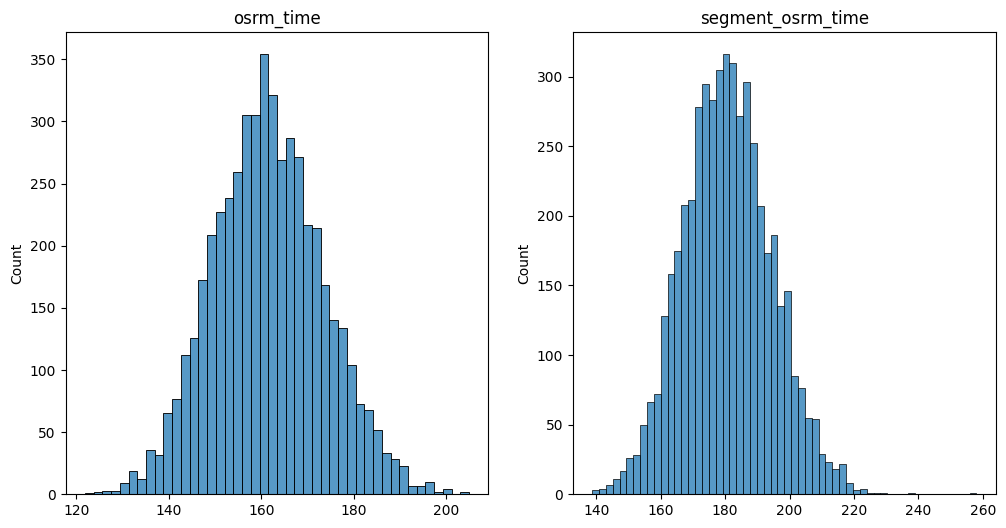

In [ ]:
plt.figure(figsize = (12,6))
for i in range(2):
  plt.subplot(1,2,i+1)
  sns.histplot(subsetsamplemean[i])
  plt.title(subset[i])
plt.show()

* Even the Histogram shows that they are not following Normal Distribution
* Let's do QQ Plot also

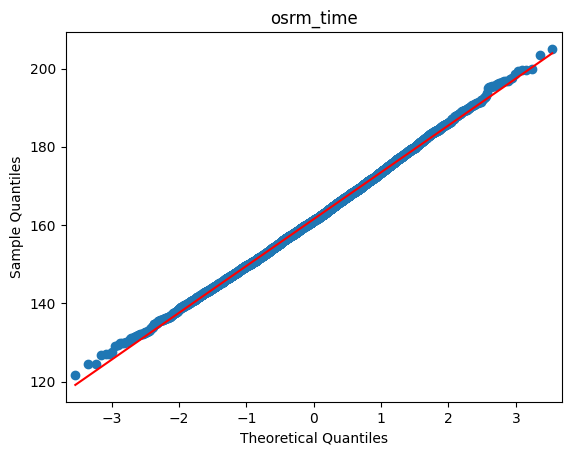

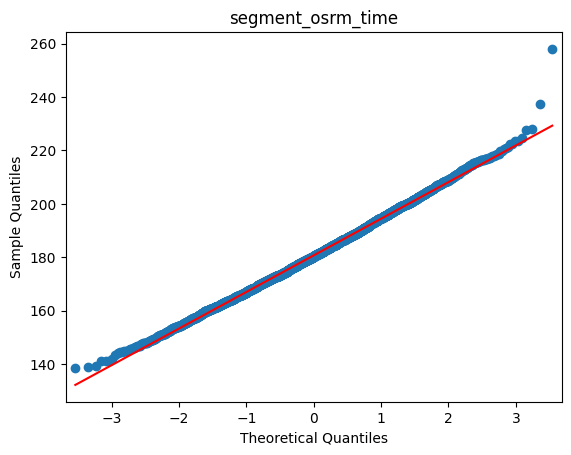

In [ ]:
for i in range(2):
   qqplot( np.array(subsetsamplemean[i]) , line="s")
   plt.title(subset[i])
   plt.show()

* From Shapiro, Histogram & QQ plot--> we can conclude that both data sets sample means are not following Normal Distribution, slightly deviated
* Now we will do Levene test to check for equal Variances of datasets

In [ ]:
# Ho: Variances are equal
# Ha: Variances are not equal
levene_stat, p_value = levene(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to reject Ho")
    print("Variances are equal")

8.349482669010088e-08
Reject Ho
Variances are not equal


* Both Datasets do not have equal Variance
* T-Test Independent is valid on the assumptions that 1. Sample means of 2 data sets follow Normal Distribution & Datasets Have Equal Variances
* But both of them are not valid
* so we will **Non-Paramteric Independent sample T-test**

In [ ]:
# subset = ["osrm_time","segment_osrm_time"]

#H0: mu1 >= mu2
#Ha : mu1 < mu2

kruskal_stat, p_value= mannwhitneyu(data2[subset[0]],data2[subset[1]],alternative = "less")
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("One or more groups have different mean")
else:
    print("Fail to reject H0")
    print("All groups have same mean")

1.1497685429874432e-08
Reject H0
One or more groups have different mean


* From Hypothesis Testing we can conclude that, **"osrm_time" is less than "segment_osrm_time" for a given trip_uuid**

## actual_distance_to_destination and osrm_distance

In [ ]:
subset = ["actual_distance_to_destination","osrm_distance"]

In [ ]:
subsetsamplemean = [[np.mean(data2[i].sample(500)) for k in range(5000)] for i in subset]

* let's check for Normal Distribution of both Data sets

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in range(2):
  test_stat, p_value = shapiro(subsetsamplemean[i])
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(subset[i],"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(subset[i],"Data is Gaussian")
  print()

1.8086872159983614e-06
Reject H0
actual_distance_to_destination Data is Not Gaussian

2.4716477128094994e-05
Reject H0
osrm_distance Data is Not Gaussian



* Let us plot Histplot to check how data actually looks

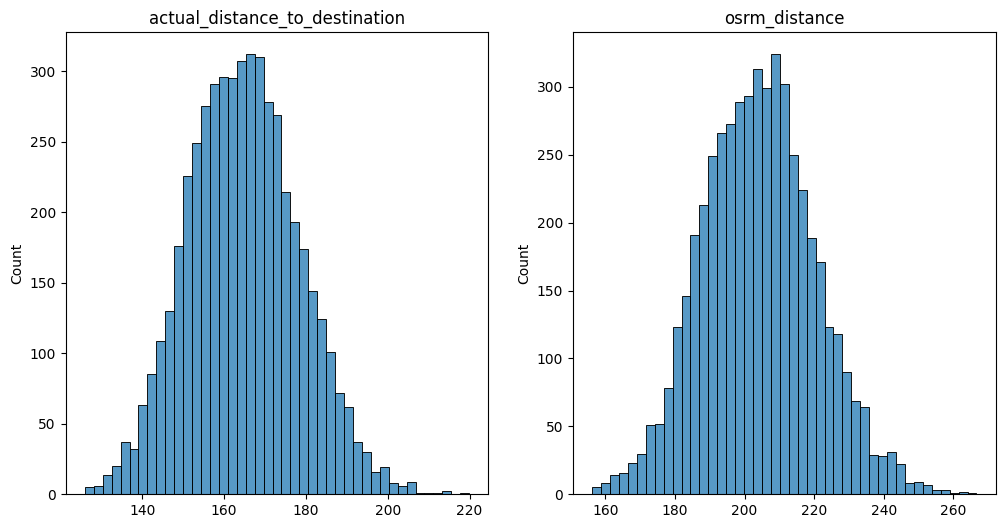

In [ ]:
plt.figure(figsize = (12,6))
for i in range(2):
  plt.subplot(1,2,i+1)
  sns.histplot(subsetsamplemean[i])
  plt.title(subset[i])
plt.show()

* Even the Histogram shows that they are not following Normal Distribution
* Let's do QQ Plot also

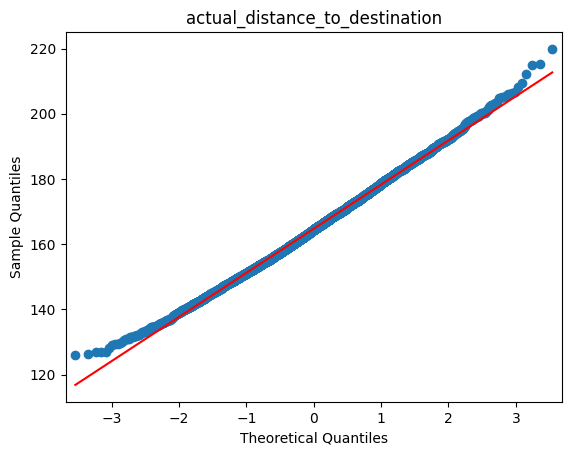

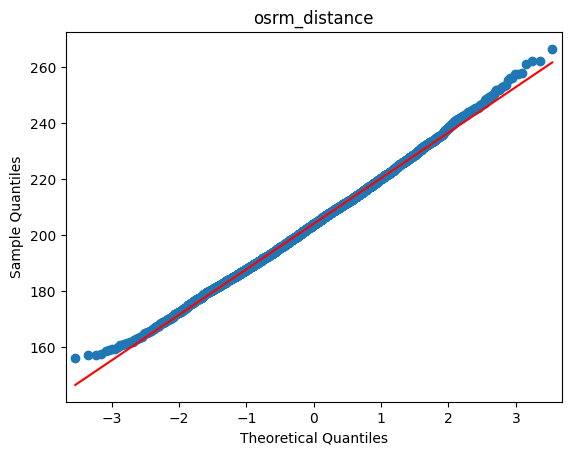

In [ ]:
for i in range(2):
   qqplot( np.array(subsetsamplemean[i]) , line="s")
   plt.title(subset[i])
   plt.show()

* From Shapiro, Histogram & QQ plot--> we can conclude that both data sets sample means are not following Normal Distribution, slightly deviated
* Now we will do Levene test to check for equal Variances of datasets

In [ ]:
# Ho: Variances are equal
# Ha: Variances are not equal
levene_stat, p_value = levene(data2[subset[0]],data2[subset[1]])
print(p_value)
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to reject Ho")
    print("Variances are equal")

1.5344941235406327e-17
Reject Ho
Variances are not equal


* Both Datasets do not have equal Variance
* T-Test Independent is valid on the assumptions that 1. Sample means of 2 data sets follow Normal Distribution & Datasets Have Equal Variances
* But both of them are not valid
* so we will **Non-Paramteric Independent sample T-test**

In [ ]:
# subset = ["actual_distance_to_destination","osrm_distance"]

#H0: mu1 >= mu2
#Ha : mu1 < mu2

kruskal_stat, p_value= mannwhitneyu(data2[subset[0]],data2[subset[1]],alternative = "less")
print(p_value)
if p_value < 0.05:
    print("Reject H0")
    print("One or more groups have different mean")
else:
    print("Fail to reject H0")
    print("All groups have same mean")

3.612957871564052e-76
Reject H0
One or more groups have different mean


* From Hypothesis Testing we can conclude that, **"actual_distance_to_destination" is less than "osrm_distance" for a given trip_uuid**

# **Feature Engineering**

### Eliminate Reduntant features

In [ ]:
data2.shape

(14817, 29)

In [ ]:
data2.drop(columns = ["trip_creation_time","source_name","destination_name"], axis = 1,inplace= True)

In [ ]:
data2.shape

(14817, 26)

## Encoding : Non-Numerical to Numerical

* We have to Convert all Non Numerical to Numerical Before feeding to Model
* we will use following to to convert all the Categorical data to Numerical
** "One-Hot Encoding" for Non Numerical features with 2 values [in Problem statemtent "One-Hot Encoding" explicity Requested, else we can be "label Encoder" also]
** "Target Encoder" for Non Numerical features with more than 2 values with **"actual_time"** as Target"

### Label Encoding

* Creating a Label Encoder Object

#### data

In [ ]:
le=LabelEncoder()

In [ ]:
data2["data"]=le.fit_transform(data2["data"])
data2["data"].value_counts()

1    10654
0     4163
Name: data, dtype: int64

1 --> Training Data
0 --> Test Data

### One-Hot Encoding

#### route_type

* As Explicity asked in the Problem statement, we are converting "route_type" Categorical to Numerical with One Hot Encoding

In [ ]:
data2["route_type"].value_counts()

Carting    8908
FTL        5909
Name: route_type, dtype: int64

In [ ]:
data2 = pd.get_dummies(data2, columns = ["route_type"])

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817 entries, 0 to 14816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   trip_uuid                       14817 non-null  object  
 1   data                            14817 non-null  int64   
 2   route_schedule_uuid             14817 non-null  object  
 3   source_center                   14817 non-null  object  
 4   destination_center              14817 non-null  object  
 5   start_scan_to_end_scan          14817 non-null  float64 
 6   actual_distance_to_destination  14817 non-null  float64 
 7   actual_time                     14817 non-null  float64 
 8   osrm_time                       14817 non-null  float64 
 9   osrm_distance                   14817 non-null  float64 
 10  segment_actual_time             14817 non-null  float64 
 11  segment_osrm_time               14817 non-null  float64 
 12  segment_osrm_dista

* we can see "route_type" category columns has been One Hot Encoded --> it converted into 2 Numerical columns : route_type_Carting & route_type_FTL
* Now we will converts other Non-Numricl columns with >2 group using Target Encoder

### Target Encoding

* As we are working to Build Forecast Models for "Actual_time", we will use it as Target for converting Categorical to Numerical using TargetEncoder

* Creating as TargetEncoder Object

In [ ]:
te=TargetEncoder()

#### source_center

In [ ]:
data2["source_center"].value_counts()

IND000000ACB    948
IND421302AAG    811
IND562132AAA    731
IND560099AAB    426
IND160002AAC    370
               ... 
IND504215AAA      1
IND844101AAB      1
IND284403AAA      1
IND621212AAA      1
IND303338AAB      1
Name: source_center, Length: 868, dtype: int64

In [ ]:
data2["source_center"]=te.fit_transform(data2["source_center"],data2["actual_time"])
data2["source_center"].value_counts()

754.231013    948
469.427867    811
553.675787    731
99.046948     426
638.697297    370
             ... 
339.820623      1
351.660494      1
364.931559      1
324.858149      1
344.894854      1
Name: source_center, Length: 789, dtype: int64

#### others

In [ ]:
data2.columns

Index(['trip_uuid', 'data', 'route_schedule_uuid', 'source_center',
       'destination_center', 'start_scan_to_end_scan',
       'actual_distance_to_destination', 'actual_time', 'osrm_time',
       'osrm_distance', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'od_total_time', 'trip_creation_hour',
       'trip_creation_day', 'trip_creation_week', 'trip_creation_month',
       'trip_creation_year', 'source_state', 'source_city', 'source_place',
       'destination_state', 'destination_city', 'destination_place',
       'route_type_Carting', 'route_type_FTL'],
      dtype='object')

In [ ]:
nonnumerical = ['destination_center','trip_uuid','route_schedule_uuid','trip_creation_hour',
       'trip_creation_day', 'trip_creation_week', 'trip_creation_month',
       'trip_creation_year', 'source_state', 'source_city', 'source_place',
       'destination_state', 'destination_city', 'destination_place']

In [ ]:
for i in nonnumerical:
  data2[i]=te.fit_transform(data2[i],data2["actual_time"])

In [ ]:
for i in data2.columns:
  print(i,"-->",data2[i].dtype,"-->",data2[i].nunique())

trip_uuid --> float64 --> 1853
data --> int64 --> 2
route_schedule_uuid --> float64 --> 1443
source_center --> float64 --> 789
destination_center --> float64 --> 840
start_scan_to_end_scan --> float64 --> 2208
actual_distance_to_destination --> float64 --> 14801
actual_time --> float64 --> 1853
osrm_time --> float64 --> 817
osrm_distance --> float64 --> 14734
segment_actual_time --> float64 --> 1890
segment_osrm_time --> float64 --> 1242
segment_osrm_distance --> float64 --> 14754
od_total_time --> float64 --> 14817
trip_creation_hour --> float64 --> 24
trip_creation_day --> float64 --> 22
trip_creation_week --> float64 --> 4
trip_creation_month --> float64 --> 2
trip_creation_year --> float64 --> 1
source_state --> float64 --> 33
source_city --> float64 --> 613
source_place --> float64 --> 659
destination_state --> float64 --> 41
destination_city --> float64 --> 684
destination_place --> float64 --> 714
route_type_Carting --> uint8 --> 2
route_type_FTL --> uint8 --> 2


* All Feature have been converted to Numerical data type

## Scaling of Numerical Categories

* Before Scaling we will store the Row index for test and Tain data, so that we can separate data after Scaling

In [ ]:
data2.shape

(14817, 27)

In [ ]:
testtrain = data2["data"]
data2.drop(columns = ["data"],axis=1,inplace=True)

In [ ]:
data2.shape

(14817, 26)

* From PCA Mathematical Derivation, we know that if Any Feature's Mean is "0", it will be easy to do Computation
* Also If Feature's Mean = 0, then Model Development will be good
* So we will do Standardization instead of Normalization

### Standardization

In [ ]:
scaler = StandardScaler()

In [ ]:
standardized = scaler.fit_transform(data2)

In [ ]:
standardized

array([[ 2.14625072,  0.75265239,  0.92618362, ...,  1.46387707,
        -1.22781549,  1.22781549],
       [-0.38146143, -0.24588095, -0.29061509, ..., -0.20542008,
         0.81445462, -0.81445462],
       [ 5.32593091,  5.1735464 ,  0.79201088, ...,  0.78807576,
        -1.22781549,  1.22781549],
       ...,
       [-0.13385608, -0.39274303, -0.03958484, ...,  0.7209205 ,
         0.81445462, -0.81445462],
       [-0.16592008, -0.18628031, -0.45690199, ..., -0.42665845,
         0.81445462, -0.81445462],
       [-0.14632542, -0.13928955, -0.43218183, ..., -0.3540543 ,
        -1.22781549,  1.22781549]])

lets convert standardized data into our initial DataFrame Format

In [ ]:
datafinal = pd.DataFrame(standardized,columns = data2.columns)

In [ ]:
datafinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817 entries, 0 to 14816
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   trip_uuid                       14817 non-null  float64
 1   route_schedule_uuid             14817 non-null  float64
 2   source_center                   14817 non-null  float64
 3   destination_center              14817 non-null  float64
 4   start_scan_to_end_scan          14817 non-null  float64
 5   actual_distance_to_destination  14817 non-null  float64
 6   actual_time                     14817 non-null  float64
 7   osrm_time                       14817 non-null  float64
 8   osrm_distance                   14817 non-null  float64
 9   segment_actual_time             14817 non-null  float64
 10  segment_osrm_time               14817 non-null  float64
 11  segment_osrm_distance           14817 non-null  float64
 12  od_total_time                   

### Standardized Data

In [ ]:
datafinal.shape

(14817, 26)

In [ ]:
datafinal.head()

trip_uuid  route_schedule_uuid  source_center  destination_center  \
0   2.146251             0.752652       0.926184            1.395621   
1  -0.381461            -0.245881      -0.290615           -0.206382   
2   5.325931             5.173546       0.792011            0.747063   
3  -0.531093            -0.562513      -1.408815           -1.132277   
4  -0.028757            -0.085846      -0.316435           -0.119761   

   start_scan_to_end_scan  actual_distance_to_destination  actual_time  \
0                2.623702                        2.162092     2.146251   
1               -0.532593                       -0.298944    -0.381461   
2                5.165134                        5.772935     5.325931   
3               -0.654047                       -0.482362    -0.531093   
4                0.282670                       -0.121257    -0.028757   

   osrm_time  osrm_distance  segment_actual_time  ...  trip_creation_month  \
0   2.047585       2.124848             2.146791  ...             0.370449   
1  -0.344144      -0.321920            -0.382742  ...             0.370449   
2   5.817598       5.804050             5.310954  ...             0.370449   
3  -0.539462      -0.498578            -0.530163  ...             0.370449   
4  -0.163566      -0.155387            -0.024976  ...             0.370449   

   trip_creation_year  source_state  source_city  source_place  \
0                 0.0      1.084445     0.487163      1.038697   
1                 0.0     -0.661491    -0.254223     -0.315120   
2                 0.0     -0.661491     0.933378      0.889415   
3                 0.0     -0.645420    -1.490880      0.054030   
4                 0.0     -0.661491    -0.283372     -0.755174   

   destination_state  destination_city  destination_place  route_type_Carting  \
0           1.099760          1.509164           1.463877           -1.227815   
1          -0.635412         -0.187413          -0.205420            0.814455   
2           0.766495          0.781831           0.788076           -1.227815   
3          -0.917633         -1.364243          -1.170208            0.814455   
4          -0.635412         -0.084897          -0.354054           -1.227815   

   route_type_FTL  
0        1.227815  
1       -0.814455  
2        1.227815  
3       -0.814455  
4        1.227815  

[5 rows x 26 columns]

In [ ]:
datafinal.describe()

trip_uuid  route_schedule_uuid  source_center  destination_center  \
count  1.481700e+04         1.481700e+04   1.481700e+04        14817.000000   
mean   1.191671e-15         1.352319e-16   3.452728e-17            0.000000   
std    1.000034e+00         1.000034e+00   1.000034e+00            1.000034   
min   -6.201601e-01        -1.373608e+00  -1.605809e+00           -1.361388   
25%   -5.168428e-01        -4.508752e-01  -7.163032e-01           -0.843837   
50%   -3.707734e-01        -2.348909e-01  -1.360075e-01           -0.186589   
75%    2.290126e-02         4.260768e-02   5.919698e-01            0.562946   
max    1.052386e+01         7.588890e+00   4.223425e+00            3.512398   

       start_scan_to_end_scan  actual_distance_to_destination   actual_time  \
count            1.481700e+04                    1.481700e+04  1.481700e+04   
mean             3.260910e-17                   -2.373751e-17  3.548638e-17   
std              1.000034e+00                    1.000034e+00  1.000034e+00   
min             -7.709467e-01                   -5.091246e-01 -6.201601e-01   
25%             -5.796561e-01                   -4.638208e-01 -5.168428e-01   
50%             -3.807746e-01                   -3.798696e-01 -3.707734e-01   
75%              1.612154e-01                    3.450474e-04  2.290126e-02   
max              1.118472e+01                    6.621482e+00  1.052386e+01   

          osrm_time  osrm_distance  segment_actual_time  ...  \
count  1.481700e+04   1.481700e+04         1.481700e+04  ...   
mean   4.603638e-17   3.260910e-17         4.411820e-17  ...   
std    1.000034e+00   1.000034e+00         1.000034e+00  ...   
min   -5.726293e-01  -5.272157e-01        -6.200543e-01  ...   
25%   -4.878685e-01  -4.685028e-01        -5.175785e-01  ...   
50%   -3.736257e-01  -3.745471e-01        -3.719551e-01  ...   
75%    2.438156e-02   1.115146e-02         2.356531e-02  ...   
max    6.893692e+00   7.116244e+00         1.056418e+01  ...   

       trip_creation_month  trip_creation_year  source_state   source_city  \
count         1.481700e+04             14817.0  1.481700e+04  1.481700e+04   
mean         -1.657310e-15                 0.0  4.757092e-16 -1.266000e-16   
std           1.000034e+00                 0.0  1.000034e+00  1.000034e+00   
min          -2.699428e+00                 0.0 -2.173775e+00 -1.601270e+00   
25%           3.704488e-01                 0.0 -6.614908e-01 -6.005740e-01   
50%           3.704488e-01                 0.0 -3.639566e-01 -2.638064e-02   
75%           3.704488e-01                 0.0  9.810524e-01  5.366739e-01   
max           3.704488e-01                 0.0  4.100426e+00  2.957775e+00   

       source_place  destination_state  destination_city  destination_place  \
count  1.481700e+04       1.481700e+04      1.481700e+04       1.481700e+04   
mean   1.457819e-16       1.150909e-17     -2.512819e-16       7.672730e-18   
std    1.000034e+00       1.000034e+00      1.000034e+00       1.000034e+00   
min   -1.778412e+00      -2.021607e+00     -1.407676e+00      -1.408943e+00   
25%   -7.194090e-01      -9.176329e-01     -8.226134e-01      -7.943877e-01   
50%   -3.791219e-02      -1.850890e-01     -8.467698e-02      -1.406023e-01   
75%    4.989239e-01       9.333450e-01      6.226045e-01       5.962239e-01   
max    3.217637e+00       2.940055e+00      2.858012e+00       3.669570e+00   

       route_type_Carting  route_type_FTL  
count        1.481700e+04    1.481700e+04  
mean         4.028183e-17    1.246819e-17  
std          1.000034e+00    1.000034e+00  
min         -1.227815e+00   -8.144546e-01  
25%         -1.227815e+00   -8.144546e-01  
50%          8.144546e-01   -8.144546e-01  
75%          8.144546e-01    1.227815e+00  
max          8.144546e-01    1.227815e+00  

[8 rows x 26 columns]

<Axes: >

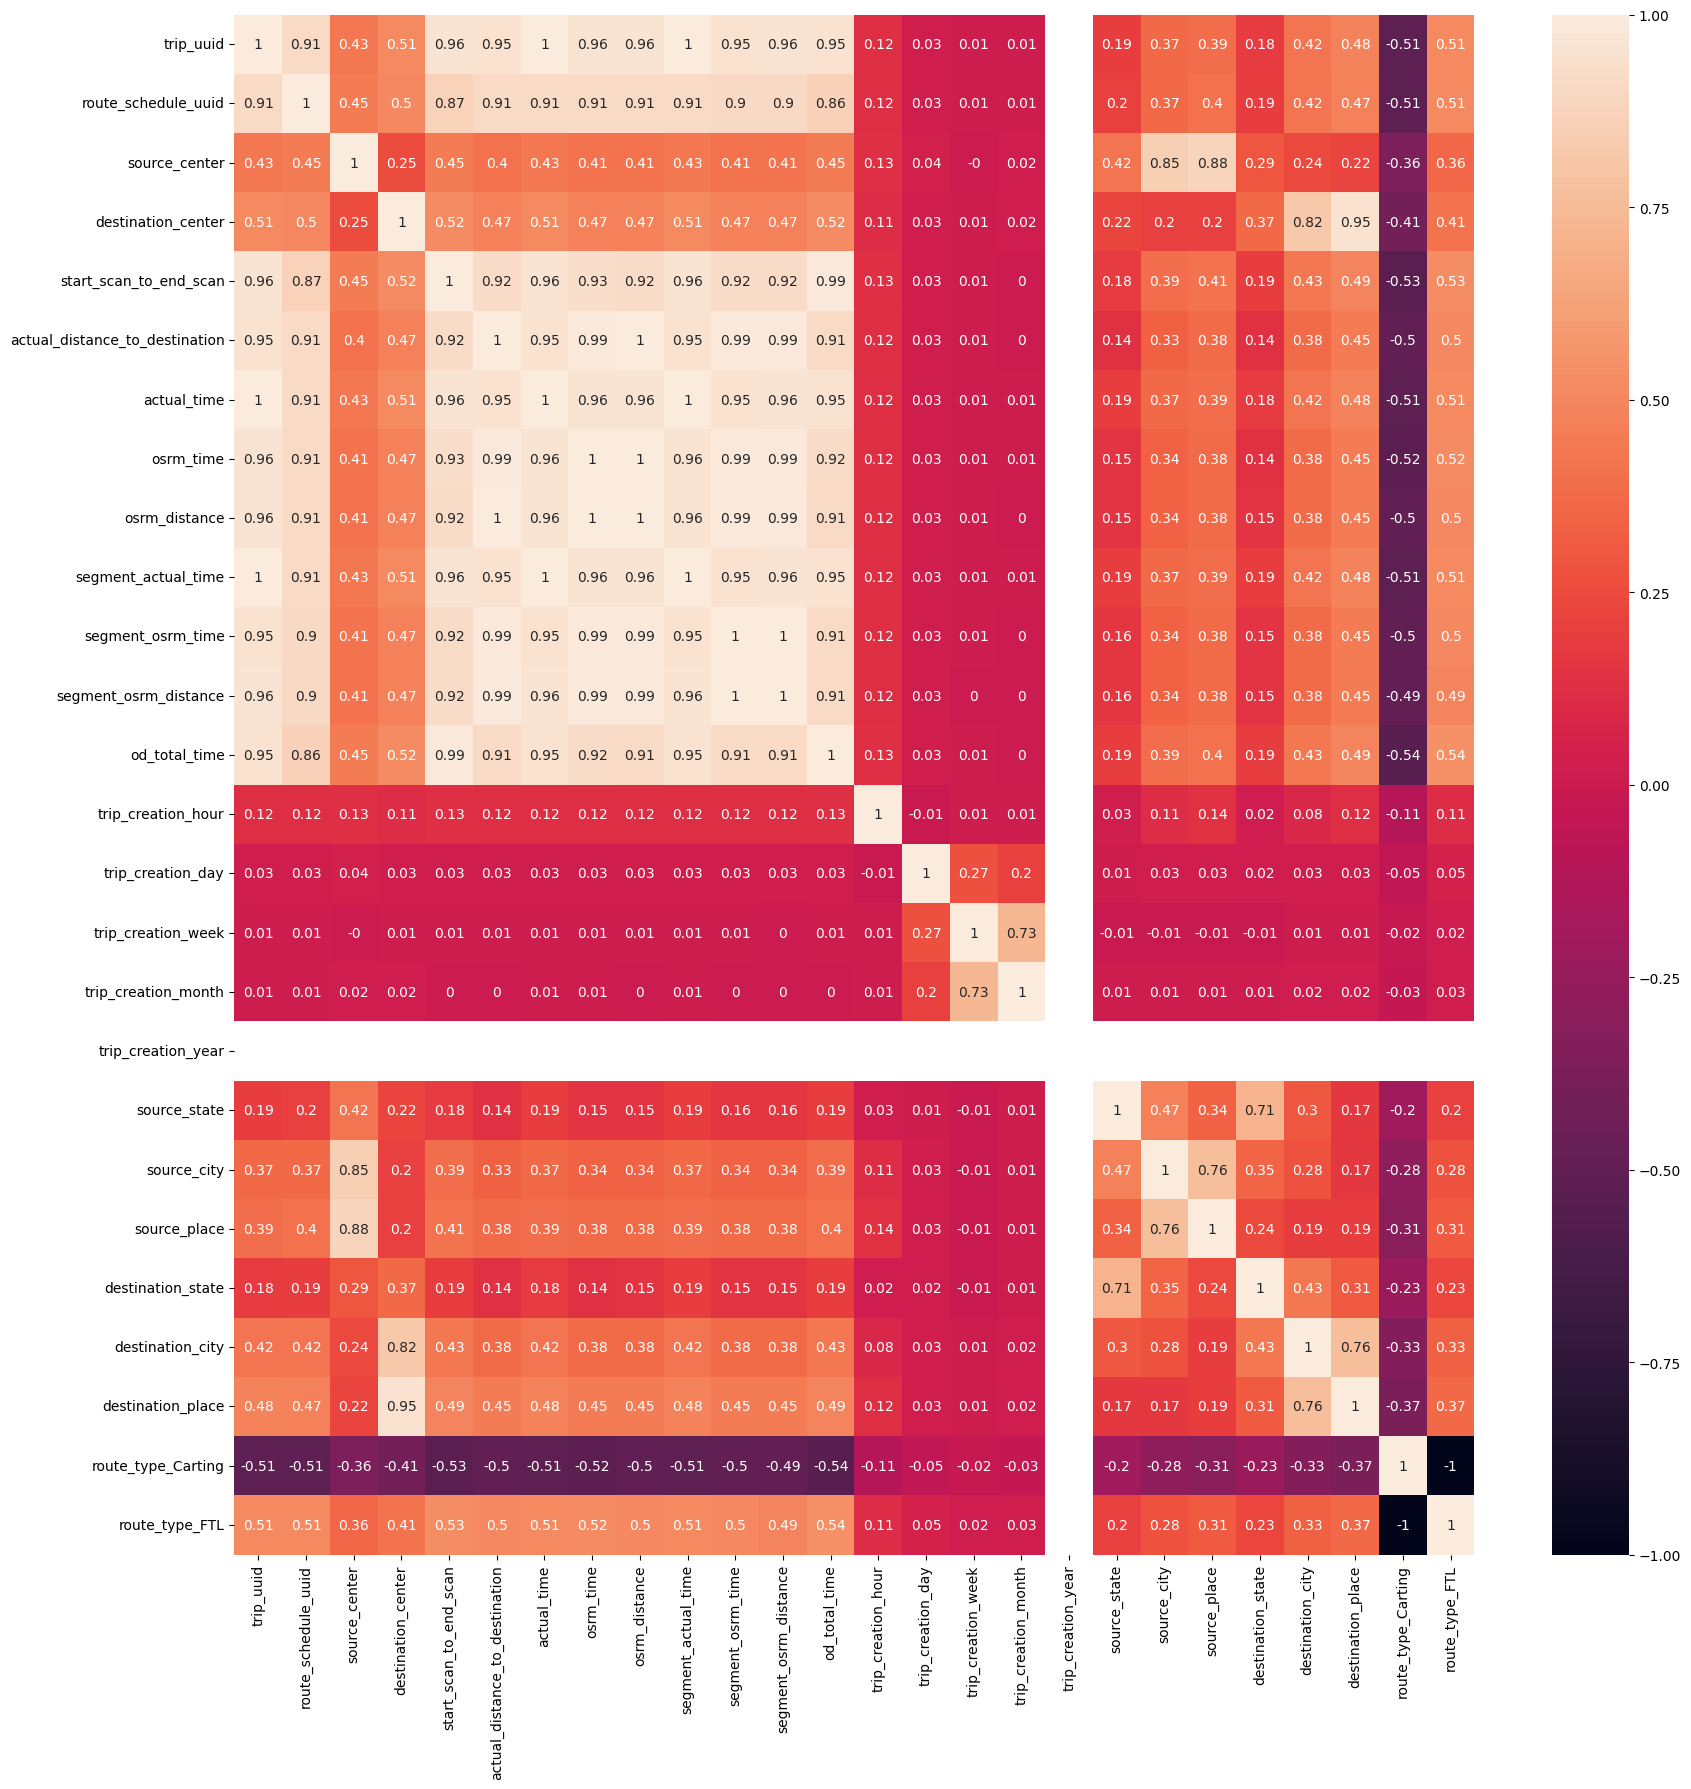

In [ ]:
plt.figure(figsize = (20,20))
sns.heatmap(round(datafinal.corr(),2),annot=True)

* Actual_time for Delivery is very well dependent on Source & Destination - City & Place
* Actual_time for delivery is comparatively less dependent on Source & Destination State & Time of Booking[hour,day,week,month]

### Normalization

In [ ]:
# H0 : Data is Gaussian
# Ha : Data is not Gaussian
for i in data2.columns:
  test_stat, p_value = shapiro(data2[i].sample(5000))
  print(p_value)
  if p_value < 0.05:
       print("Reject H0")
       print(i,"Data is Not Gaussian")
  else:
       print("Fail to reject H0")
       print(i,"Data is Gaussian")

0.0
Reject H0
trip_uuid Data is Not Gaussian
0.0
Reject H0
route_schedule_uuid Data is Not Gaussian
1.0856286599155977e-38
Reject H0
source_center Data is Not Gaussian
0.0
Reject H0
destination_center Data is Not Gaussian
0.0
Reject H0
start_scan_to_end_scan Data is Not Gaussian
0.0
Reject H0
actual_distance_to_destination Data is Not Gaussian
0.0
Reject H0
actual_time Data is Not Gaussian
0.0
Reject H0
osrm_time Data is Not Gaussian
0.0
Reject H0
osrm_distance Data is Not Gaussian
0.0
Reject H0
segment_actual_time Data is Not Gaussian
0.0
Reject H0
segment_osrm_time Data is Not Gaussian
0.0
Reject H0
segment_osrm_distance Data is Not Gaussian
0.0
Reject H0
od_total_time Data is Not Gaussian
1.6944337293091785e-31
Reject H0
trip_creation_hour Data is Not Gaussian
0.0
Reject H0
trip_creation_day Data is Not Gaussian
0.0
Reject H0
trip_creation_week Data is Not Gaussian
0.0
Reject H0
trip_creation_month Data is Not Gaussian
1.0
Fail to reject H0
trip_creation_year Data is Gaussian
0.0
Re

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


*
* In Practice, we have observed that All the Numericals are not following Normal Distribution, so we cannot do Stardadization
* For the sake of better convergence, we are using Standardization above
* Now we will do Normalization also but only for practice, we will not use it further

In [ ]:
Normscaler = MinMaxScaler()

In [ ]:
normalised = Normscaler.fit_transform(data2)

In [ ]:
normalised

array([[0.24824169, 0.23723967, 0.43436107, ..., 0.56568126, 0.        ,
        1.        ],
       [0.02141944, 0.12582728, 0.22562033, ..., 0.23698325, 1.        ,
        0.        ],
       [0.53356777, 0.7305055 , 0.41134386, ..., 0.43261056, 0.        ,
        1.        ],
       ...,
       [0.04363811, 0.10944099, 0.26868435, ..., 0.41938715, 1.        ,
        0.        ],
       [0.04076087, 0.13247729, 0.19709396, ..., 0.19341964, 1.        ,
        0.        ],
       [0.04251918, 0.13772033, 0.20133468, ..., 0.20771598, 0.        ,
        1.        ]])

In [ ]:
datafinal2 = pd.DataFrame(normalised,columns = data2.columns)

In [ ]:
datafinal2.describe()

trip_uuid  route_schedule_uuid  source_center  destination_center  \
count  14817.000000         14817.000000   14817.000000        14817.000000   
mean       0.055650             0.153262       0.275475            0.279329   
std        0.089737             0.111580       0.171555            0.205186   
min        0.000000             0.000000       0.000000            0.000000   
25%        0.009271             0.102955       0.152594            0.106191   
50%        0.022379             0.127054       0.252143            0.241044   
75%        0.057705             0.158016       0.377027            0.394833   
max        1.000000             1.000000       1.000000            1.000000   

       start_scan_to_end_scan  actual_distance_to_destination   actual_time  \
count            14817.000000                    14817.000000  14817.000000   
mean                 0.064484                        0.071400      0.055650   
std                  0.083645                        0.140245      0.089737   
min                  0.000000                        0.000000      0.000000   
25%                  0.016000                        0.006353      0.009271   
50%                  0.032635                        0.018127      0.022379   
75%                  0.077968                        0.071448      0.057705   
max                  1.000000                        1.000000      1.000000   

          osrm_time  osrm_distance  segment_actual_time  ...  \
count  14817.000000   14817.000000         14817.000000  ...   
mean       0.076695       0.068976             0.055440  ...   
std        0.133939       0.130835             0.089415  ...   
min        0.000000       0.000000             0.000000  ...   
25%        0.011352       0.007681             0.009163  ...   
50%        0.026654       0.019974             0.022183  ...   
75%        0.079961       0.070435             0.057547  ...   
max        1.000000       1.000000             1.000000  ...   

       trip_creation_month  trip_creation_year  source_state   source_city  \
count         14817.000000             14817.0  14817.000000  14817.000000   
mean              0.879328                 0.0      0.346462      0.351229   
std               0.325757                 0.0      0.159388      0.219352   
min               0.000000                 0.0      0.000000      0.000000   
25%               1.000000                 0.0      0.241032      0.219497   
50%               1.000000                 0.0      0.288454      0.345443   
75%               1.000000                 0.0      0.502825      0.468946   
max               1.000000                 0.0      1.000000      1.000000   

       source_place  destination_state  destination_city  destination_place  \
count  14817.000000       14817.000000      14817.000000       14817.000000   
mean       0.355964           0.407446          0.330000           0.277432   
std        0.200165           0.201552          0.234437           0.196915   
min        0.000000           0.000000          0.000000           0.000000   
25%        0.211968           0.222501          0.137155           0.121011   
50%        0.348375           0.370142          0.310149           0.249746   
75%        0.455827           0.595557          0.475956           0.394833   
max        1.000000           1.000000          1.000000           1.000000   

       route_type_Carting  route_type_FTL  
count        14817.000000    14817.000000  
mean             0.601201        0.398799  
std              0.489668        0.489668  
min              0.000000        0.000000  
25%              0.000000        0.000000  
50%              1.000000        0.000000  
75%              1.000000        1.000000  
max              1.000000        1.000000  

[8 rows x 26 columns]

## Final data - Dividing Data for Training & Test

* we will use "testtrain" & divide data into X --> our Features
Y --> Desired Outcome [ Our desired outcome is "actual_time"]
* we will have 4 below datasets
** Xtrain
** Xtest
** ytrain
** ytest

In [ ]:
y = data2["actual_time"]
X = datafinal.drop(columns = ["actual_time"],axis=1)

In [ ]:
X.shape, y.shape

((14817, 25), (14817,))

In [ ]:
Xtrain = X.loc[testtrain == 1]
Xtest = X.loc[testtrain == 0]
ytrain = y.loc[testtrain == 1]
ytest = y.loc[testtrain == 0]

In [ ]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((10654, 25), (4163, 25), (10654,), (4163,))

# **Bussiness Insights**

* The DataSet provided is between 2018-09-12 00:00:16.535741 & 2018-10-03 23:59:42.701692
* Training : Test Data Ratio use = 72:28
* 60% trips are of Cart Types, rest are of FTL type
* Trip creations are lowest in the Noon and Starts to increase and reaches peak in midnight
* More Number of Trip are created in the moiddle of the month and Number of trips are less at start and End of month
* There is not much effect of Week ina month for trip Creation
* Top 5 Source States:Maharastra,Karnataka,Harayana,Tamilnadu,Delhi
* Top 5 destination States: Maharastra,Karnataka,Harayana,Tamilnadu,Telangana
* Top5 Source Cities:Bengaluru,Gurgoan,Mumbai,Bhiwandi,Delhi
* Top5 Destination Cities: Bengaluru,Mumbai,Gurgoan,Hyderabad,Bhiwandi

* "od_total_time" is greater than "start_scan_to_end_scan" for a given trip_uuid
* "actual_time" is always greater than "osrm_time" for a given trip_uuid
* "actual_time" & "segment_actual_time" have approx same mean for a given trip_uuid
* "osrm_distance" is less than "segment_osrm_distance" for a given trip_uuid
* "osrm_time" is less than "segment_osrm_time" for a given trip_uuid
* "actual_distance_to_destination" is less than "osrm_distance" for a given trip_uuid

# **Recommendations**

* Major Traffic is found in Maharastra, Karnataka,Haryana --> Appropriate infrastructure & Manpower needs to be maintained to reduce logitics Delays
* Carting Type Trip from among manjor Cities (Bengaluru, Gurugaon,Mumbai,Hyderabad,Delhi,Bhiwandi) can be Converted to FTL by delhivery to further Optimize the Total trip Duration
* High Trip Creation goes on during night time, & in the middle of the month, so appropriate Resource to be maintained to reduce process bottle Necks
* Actual Trip Time is alwasy greater than Osrm predicted time, so Accordingly Buffer to be added , so that no false commitment at customer end
* Actual Distance_to_Destination is statistically lower than osrm distance, so correction might be needed for distance calculation so that price of trip can be optimised according & best value can be given to customer